### Model inspired by:

- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen

### Implementation aspects:

- This implementation is more like pseudo steady-state finite difference method rather than fully dynamic FEM

In [1]:
import numpy as np
import inspect
import matplotlib.pyplot as plt
import scipy
from datetime import datetime
from scipy.optimize import root
from scipy.integrate import solve_ivp
from scipy import interpolate

In [2]:
import sys

In [3]:
sys.path.insert(0, "../../../miscellaneous/Ocean_Intella_1/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../miscellaneous/Ocean_Intella_1/PythonVehicleSimulator-master/src")

In [4]:
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

### Modelling data:

In [5]:
mp = 96       #  (submerged pipe weight) [kg/m]
N = 100        # number of modelling nodes

In [6]:
mi = [mp for i in range(N)]

In [7]:
# Vessel:

# L - the hull length
# Xg - x-center of gravity

L = 84.6 # [m]
B = 12
H = 13
Xg = L/2 # [m]
mn = 27_162_500 #123_000_000   # mass of the vessel, [kg]

In [8]:
lx, ly, lz = L/2, B/2, H/2

In [9]:
vessel_mass = mn/L # mass over length of the vessel

In [10]:
diag_Jrho0 = 1e2*np.array([1, 1, 2]) # [m^4] 
Jrho0 = np.diag(diag_Jrho0)

In [11]:
qw = 1025 # Water density [kg/m3]
d0 = 0.761 # Outer diameter of pipe, [m]
dI= 0.69 # Inner diameter of pipe, [m]

In [12]:
Ar=np.pi*((d0/2)**2-(dI/2)**2)   

In [13]:
E = 210e9

In [14]:
h = 100 # water depth

In [15]:
# Fossen book p.181
def vessel_inertia_moment(mn, Xg, L):
    r = 0.25*L
    Ir = mn*r**2
    Iz=mn*Xg**2 + Ir
    return Iz

In [16]:
vessel_inertia = vessel_inertia_moment(mn, Xg, L)

In [17]:
# Underwater current: 
dv1_curr = np.zeros(N)
dv2_curr = np.zeros(N)
dv3_curr = np.zeros(N)

In [18]:
# Constants: 

In [19]:
diag_DT = 1.5*np.array([1, 1, 1])
DT=np.diag(diag_DT)

In [20]:
diag_CT = 1e9*np.array([1, 1, 1 ])  
CT=np.diag(diag_CT)

In [21]:
diag_CR = 1e11*np.array([1, 1, 1])
CR=np.diag(diag_CR)

In [22]:
diag_DR = 1.5*np.array([1, 1, 1])
DR=np.diag(diag_DR)

In [23]:
# for testing:

In [24]:
φ = np.random.rand(N)
θ = np.random.rand(N)
ψ = np.random.rand(N)

In [25]:
φ

array([0.2473128 , 0.15679125, 0.01872996, 0.38935352, 0.6019885 ,
       0.27728613, 0.42958575, 0.33842272, 0.73676262, 0.13846448,
       0.44309174, 0.33107317, 0.20639292, 0.229229  , 0.81392653,
       0.10263538, 0.86527168, 0.05499704, 0.69908468, 0.53523369,
       0.78253021, 0.41283085, 0.40904222, 0.59249969, 0.92607619,
       0.13940113, 0.41236361, 0.96412047, 0.27759994, 0.20539296,
       0.10885221, 0.60557925, 0.59105461, 0.47932362, 0.34811329,
       0.9285062 , 0.03163465, 0.95653209, 0.11083059, 0.19442281,
       0.74338125, 0.86743926, 0.00731238, 0.56298647, 0.96288814,
       0.74663382, 0.46296038, 0.22075195, 0.39156063, 0.95512607,
       0.48135309, 0.20447563, 0.69087546, 0.57646611, 0.53728276,
       0.28663723, 0.60646468, 0.92193676, 0.66708271, 0.14094485,
       0.52617036, 0.11609254, 0.05227181, 0.51625713, 0.23347788,
       0.26628846, 0.92811841, 0.41052223, 0.38849848, 0.8104926 ,
       0.91464447, 0.12234778, 0.16368803, 0.01147759, 0.45092

In [26]:
dφ = np.random.rand(N)
dθ = np.random.rand(N)
dψ = np.random.rand(N)

In [27]:
ddφ = np.random.rand(N)
ddθ = np.random.rand(N)
ddψ = np.random.rand(N)

In [28]:
x = np.random.rand(N)
y = np.random.rand(N)
z = np.random.rand(N)

In [29]:
dx = np.random.rand(N)
dy = np.random.rand(N)
dz = np.random.rand(N)

### Main functions:

In [30]:
def Π0(φθψ):
    φ0,θ0,ψ0=φθψ
    return np.array([[np.cos(θ0),0,np.cos(φ0)*np.sin(θ0)],
                  [0,1,-np.sin(φ0)],
                  [-np.sin(θ0),0,np.cos(φ0)*np.cos(θ0)]])

In [31]:
def Π(φ,θ,ψ):
    φθψ=np.stack((φ,θ,ψ), axis=1)
    return np.apply_along_axis(Π0, 1, φθψ)

In [32]:
Π(φ,θ,ψ)

array([[[ 9.98977498e-01,  0.00000000e+00,  4.38345849e-02],
        [ 0.00000000e+00,  1.00000000e+00, -2.44799407e-01],
        [-4.52101607e-02,  0.00000000e+00,  9.68582356e-01]],

       [[ 7.13081174e-01,  0.00000000e+00,  6.92481602e-01],
        [ 0.00000000e+00,  1.00000000e+00, -1.56149623e-01],
        [-7.01081479e-01,  0.00000000e+00,  7.04334102e-01]],

       [[ 9.42176120e-01,  0.00000000e+00,  3.35059346e-01],
        [ 0.00000000e+00,  1.00000000e+00, -1.87288693e-02],
        [-3.35118126e-01,  0.00000000e+00,  9.42010862e-01]],

       [[ 9.94065080e-01,  0.00000000e+00,  1.00644826e-01],
        [ 0.00000000e+00,  1.00000000e+00, -3.79590399e-01],
        [-1.08787029e-01,  0.00000000e+00,  9.19663932e-01]],

       [[ 7.51872854e-01,  0.00000000e+00,  5.43409140e-01],
        [ 0.00000000e+00,  1.00000000e+00, -5.66282535e-01],
        [-6.59308130e-01,  0.00000000e+00,  6.19702022e-01]],

       [[ 7.86612794e-01,  0.00000000e+00,  5.93861314e-01],
        [ 0.00

In [33]:
def w_e(φ,θ,ψ,dφ,dθ,dψ): 
    return np.einsum('ijk,ik->ij', Π(φ,θ,ψ), np.stack((dφ,dθ,dψ), axis=1))

In [34]:
w_e(φ,θ,ψ,dφ,dθ,dψ)

array([[ 6.23715789e-01,  2.56842318e-01,  3.92151862e-01],
       [ 4.23601594e-01,  6.80215857e-01, -3.04655972e-01],
       [ 9.34934864e-01,  9.23253161e-01, -2.39850898e-01],
       [ 2.49593816e-01,  1.79271875e-01,  5.75661190e-01],
       [ 2.31153591e-01,  8.39273653e-01, -1.83634771e-01],
       [ 1.15484853e+00,  2.80301228e-01,  2.86493999e-01],
       [ 4.56131377e-01,  9.47409440e-02,  8.94425736e-02],
       [ 2.59871285e-01,  8.80162295e-02,  4.60635021e-01],
       [ 8.37394287e-01,  3.44262346e-01, -7.12842563e-02],
       [ 7.63879600e-01,  6.64386545e-01,  5.42380583e-01],
       [ 6.28354534e-02,  4.96982087e-01,  1.35437711e-01],
       [ 2.44364170e-01,  4.73706401e-01,  2.24294821e-01],
       [ 8.00910773e-01,  4.07773528e-01,  1.31465624e-01],
       [ 2.88243520e-01,  7.31644848e-01, -4.10172172e-02],
       [ 4.85471767e-01, -1.19778167e-01,  2.57420991e-01],
       [ 6.71726898e-01,  4.94089892e-01, -2.61390694e-01],
       [ 7.09205007e-01, -5.30072536e-02

In [35]:
def dw_e(φ,θ,ψ,dφ,dθ,dψ,ddφ,ddθ,ddψ):
    return (np.einsum('ijk,ik->ij', Π(φ,θ,ψ), np.stack((ddφ,ddθ,ddψ), axis=1))+
        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ), np.stack((dφ,dθ,dψ), axis=1)))

In [36]:
dw_e(φ,θ,ψ,dφ,dθ,dψ,ddφ,ddθ,ddψ)

array([[ 1.15265940e+00,  7.64637524e-01,  2.57746238e-01],
       [ 1.25485386e+00,  1.20556427e+00,  2.14485150e-01],
       [ 8.86974543e-01,  1.38792666e+00, -3.41962717e-01],
       [ 5.12712243e-01,  3.71521581e-01,  9.33016516e-01],
       [ 7.16263310e-01,  1.11230668e+00,  3.68558941e-01],
       [ 1.56624386e+00,  3.87693108e-01, -1.04826637e-03],
       [ 1.27492338e+00,  5.76970595e-01, -1.40122656e-02],
       [ 1.08680790e+00,  1.85065744e-02,  7.69851589e-01],
       [ 1.60446284e+00,  9.45730768e-02, -1.61702911e-01],
       [ 9.71741983e-01,  1.26625796e+00,  8.95808966e-02],
       [ 7.72758891e-01,  5.66644585e-01,  7.31371859e-01],
       [ 1.25749679e+00,  8.40806595e-01,  7.70651276e-01],
       [ 1.47526432e+00,  6.00292729e-01, -9.68413039e-02],
       [ 7.83203164e-01,  1.16970148e+00, -6.72084522e-02],
       [ 1.31505295e+00,  5.20345395e-01,  3.23201880e-01],
       [ 1.50681526e+00,  1.07566717e+00,  1.37789513e-01],
       [ 1.23885182e+00, -2.87311458e-01

In [37]:
def phi(x,y,z): return np.stack((x,y,z), axis=1) 
def theta(φ,θ,ψ): return np.stack((φ,θ,ψ), axis=1) 

In [38]:
phi(x,y,z)

array([[0.37648877, 0.4706691 , 0.66912786],
       [0.5731227 , 0.22909356, 0.3986404 ],
       [0.77331412, 0.97157753, 0.13872797],
       [0.31879686, 0.26911011, 0.14007978],
       [0.04559167, 0.77899285, 0.30492211],
       [0.14233173, 0.96493339, 0.15275773],
       [0.08794118, 0.18547236, 0.34602019],
       [0.7526996 , 0.86635473, 0.80605232],
       [0.19013453, 0.04458248, 0.06724357],
       [0.72607521, 0.45802551, 0.42446216],
       [0.85439926, 0.59693527, 0.38692112],
       [0.18235106, 0.49069354, 0.80317827],
       [0.7894261 , 0.99581678, 0.98594955],
       [0.55609812, 0.22277866, 0.02150938],
       [0.85280333, 0.75648885, 0.03149453],
       [0.02310432, 0.18799274, 0.70403464],
       [0.11438077, 0.29787478, 0.1870015 ],
       [0.44576357, 0.53237354, 0.48232306],
       [0.01477829, 0.47288166, 0.54673366],
       [0.81771767, 0.42380098, 0.55711756],
       [0.52790412, 0.74708695, 0.82668418],
       [0.04130247, 0.83237145, 0.29172761],
       [0.

In [39]:
theta(φ,θ,ψ)

array([[2.47312799e-01, 4.52255762e-02, 1.29513774e-01],
       [1.56791246e-01, 7.76912996e-01, 7.94130444e-01],
       [1.87299644e-02, 3.41730603e-01, 5.21466238e-01],
       [3.89353518e-01, 1.09002755e-01, 1.78502978e-01],
       [6.01988499e-01, 7.19898194e-01, 7.78820376e-01],
       [2.77286132e-01, 6.65492490e-01, 8.20821145e-01],
       [4.29585754e-01, 6.99668675e-01, 6.88430288e-01],
       [3.38422720e-01, 1.64048611e-01, 8.65679951e-01],
       [7.36762616e-01, 5.42106736e-01, 2.50901406e-01],
       [1.38464477e-01, 1.36640106e-01, 9.21956913e-01],
       [4.43091741e-01, 1.99858577e-01, 9.32307005e-01],
       [3.31073170e-01, 1.41493484e-02, 6.68901722e-01],
       [2.06392924e-01, 8.04463812e-01, 4.54267592e-01],
       [2.29229005e-01, 6.04956153e-01, 4.18488060e-01],
       [8.13926534e-01, 6.21148039e-01, 1.56157318e-01],
       [1.02635380e-01, 8.26961570e-01, 4.83874991e-02],
       [8.65271681e-01, 5.96330209e-01, 5.55649417e-01],
       [5.49970413e-02, 7.88506

In [40]:
def ω(φ,θ,ψ): 
    return np.einsum('ijk,ik->ij', Π(φ,θ,ψ), theta(φ,θ,ψ))

In [41]:
ω(x,y,z)

array([[ 0.61773682,  0.22465927,  0.38387012],
       [ 0.6342122 ,  0.01292745,  0.19603798],
       [ 0.51812514,  0.87467457, -0.58259449],
       [ 0.34268963,  0.22520571,  0.04347419],
       [ 0.24644841,  0.76509576,  0.18473263],
       [ 0.20535265,  0.94326446, -0.03088672],
       [ 0.1499962 ,  0.15508214,  0.32255418],
       [ 0.93571902,  0.31532806, -0.19255277],
       [ 0.19288849,  0.03187405,  0.05749229],
       [ 0.79158702,  0.17620817, -0.03636361],
       [ 0.84946244,  0.30512842, -0.27012661],
       [ 0.53304736,  0.34504346,  0.61073219],
       [ 1.01201127,  0.29584267, -0.28488508],
       [ 0.54639166,  0.21142436, -0.10504766],
       [ 0.63442285,  0.73276946, -0.57027227],
       [ 0.15423733,  0.17172794,  0.687128  ],
       [ 0.16386801,  0.27653201,  0.14402875],
       [ 0.60496632,  0.32442141,  0.14870228],
       [ 0.26214113,  0.46480216,  0.47995087],
       [ 0.90205662,  0.01733532,  0.01103091],
       [ 0.87257168,  0.33066638,  0.165

In [42]:
def Ret(φ,θ,ψ):
    
    def Ret0(arr):
        φ,θ,ψ=arr
        Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

        Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

        Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])


        return np.array(np.dot(np.dot(Cθ,Cφ),Cψ) )
    
    arr=np.stack((φ,θ,ψ), axis=1)
    return np.apply_along_axis(Ret0, 1, arr)

In [43]:
Ret(φ,θ,ψ)

array([[[ 9.92040249e-01, -1.18045218e-01,  4.38345849e-02],
        [ 1.25222393e-01,  9.61453380e-01, -2.44799407e-01],
        [-1.32475106e-02,  2.48339936e-01,  9.68582356e-01]],

       [[ 5.77884868e-01, -4.31877657e-01,  6.92481602e-01],
        [ 7.04505201e-01,  6.92307530e-01, -1.56149623e-01],
        [-4.11972694e-01,  5.78093394e-01,  7.04334102e-01]],

       [[ 8.20077805e-01, -4.63904762e-01,  3.35059346e-01],
        [ 4.98064656e-01,  8.66937615e-01, -1.87288693e-02],
        [-2.81787138e-01,  1.82240348e-01,  9.42010862e-01]],

       [[ 9.85602094e-01, -1.35864387e-01,  1.00644826e-01],
        [ 1.64267257e-01,  9.10454500e-01, -3.79590399e-01],
        [-4.00597179e-02,  3.90657742e-01,  9.19663932e-01]],

       [[ 7.97399357e-01, -2.62413360e-01,  5.43409140e-01],
        [ 5.78959174e-01,  5.86626257e-01, -5.66282535e-01],
        [-1.70177967e-01,  7.66165036e-01,  6.19702022e-01]],

       [[ 6.59847193e-01, -4.60359014e-01,  5.93861314e-01],
        [ 7.03

In [44]:
def d_s(func, a, b, c, φ, θ, ψ): 
    
    sig = inspect.signature(func)
    num_args = len(sig.parameters)
    
    if num_args==3:
        fu = func(a, b, c)
    else:
        fu = func(a, b, c, φ, θ, ψ)

    def S(arr):
        a1, a2, a3 = arr[0],arr[1],arr[2]
        return np.array([[0, -a3, a2 ],
                         [a3, 0, -a1],
                        [-a2, a1, 0]])
    
    S0 = np.apply_along_axis(S, 1, ω(φ,θ,ψ))

    
    return np.einsum('ijk,ik->ij',S0, fu).T

In [45]:
d_s(phi,x,y,z,φ, θ, ψ).T

array([[-4.47333315e-02, -1.26094435e-01,  1.13865162e-01],
       [ 1.57319362e-01, -6.22365038e-03, -2.22600368e-01],
       [-4.25113920e-01,  3.48331799e-01, -6.98110917e-02],
       [-2.70017091e-02, -1.79020376e-02,  9.58430909e-02],
       [ 1.82410000e-02, -2.63152984e-01,  6.69556742e-01],
       [-3.66687976e-01, -4.37611791e-02,  6.18089570e-01],
       [ 1.05384695e-01, -2.35401902e-01,  9.93956222e-02],
       [-7.49497734e-01,  1.88167055e-01,  4.97644157e-01],
       [ 3.49674185e-02, -9.08948990e-02, -3.86088002e-02],
       [-4.01715665e-01,  5.32108163e-01,  1.12982209e-01],
       [-5.17592148e-01,  3.97425982e-01,  5.29805044e-01],
       [-4.71343655e-01, -1.58587561e-01,  2.03899825e-01],
       [ 5.42393439e-01, -3.30924452e-01, -1.00045096e-01],
       [-3.46682598e-02,  1.04873048e-01, -1.89894938e-01],
       [ 3.08357705e-01, -3.52405640e-01,  1.15018711e-01],
       [ 5.86790878e-01, -7.48563707e-02,  7.31565426e-04],
       [ 8.83630568e-02, -1.93203333e-01

In [46]:
d_s(theta, φ, θ, ψ, φ, θ, ψ).T

array([[-3.41652748e-03, -4.47405945e-03,  8.08634366e-03],
       [ 1.69343323e-01, -4.55032942e-01,  4.11732679e-01],
       [ 7.38579256e-03, -9.12308725e-02,  5.95207191e-02],
       [-5.91489597e-03, -2.48695102e-02,  2.80882188e-02],
       [ 1.55461841e-01, -6.30504756e-01,  4.62639404e-01],
       [ 6.24786837e-02, -4.54425269e-01,  3.47325521e-01],
       [ 1.42812656e-01, -4.16865020e-01,  3.34554009e-01],
       [-2.29880753e-01, -1.50544140e-01,  1.18396443e-01],
       [ 2.13492046e-01, -3.45187530e-01,  1.18913351e-01],
       [-1.12373884e-01, -1.18497474e-01,  3.44390264e-02],
       [-3.33729056e-01, -2.33974092e-01,  2.08766336e-01],
       [-1.44859434e-01, -1.95628285e-02,  7.21120486e-02],
       [ 1.94720075e-01, -1.77587947e-01,  2.26021474e-01],
       [ 8.94498543e-02, -1.28945101e-01,  1.37403278e-01],
       [ 3.19332484e-01, -4.27673131e-01,  3.67267113e-02],
       [ 7.52807950e-02, -9.48332407e-03,  2.39465850e-03],
       [ 2.08319982e-01, -6.72764523e-01

In [47]:
def ne(x, y, z, φ, θ, ψ):
    RET = Ret(φ,θ,ψ)
    A = np.einsum('ijk,ikp->ijp',np.einsum('ijk,kp->ijp',RET, CT), np.transpose(RET,(0,2,1))) 
    B = d_s(phi, x, y, z, φ, θ, ψ).T
#     t1=np.einsum('ijk,kp->ijp',RET, np.array([0,0,1]).reshape(3,1)).squeeze()
    return np.einsum('ijk,ik->ij', A, B 
#                      - t1
                    )

In [48]:
ne(x, y, z, φ, θ, ψ)

array([[-4.47333315e+07, -1.26094435e+08,  1.13865162e+08],
       [ 1.57319362e+08, -6.22365038e+06, -2.22600368e+08],
       [-4.25113920e+08,  3.48331799e+08, -6.98110917e+07],
       [-2.70017091e+07, -1.79020376e+07,  9.58430909e+07],
       [ 1.82410000e+07, -2.63152984e+08,  6.69556742e+08],
       [-3.66687976e+08, -4.37611791e+07,  6.18089570e+08],
       [ 1.05384695e+08, -2.35401902e+08,  9.93956222e+07],
       [-7.49497734e+08,  1.88167055e+08,  4.97644157e+08],
       [ 3.49674185e+07, -9.08948990e+07, -3.86088002e+07],
       [-4.01715665e+08,  5.32108163e+08,  1.12982209e+08],
       [-5.17592148e+08,  3.97425982e+08,  5.29805044e+08],
       [-4.71343655e+08, -1.58587561e+08,  2.03899825e+08],
       [ 5.42393439e+08, -3.30924452e+08, -1.00045096e+08],
       [-3.46682598e+07,  1.04873048e+08, -1.89894938e+08],
       [ 3.08357705e+08, -3.52405640e+08,  1.15018711e+08],
       [ 5.86790878e+08, -7.48563707e+07,  7.31565426e+05],
       [ 8.83630568e+07, -1.93203333e+08

In [49]:
d_s(ne, x, y, z, φ, θ, ψ).T

array([[ 1.59475519e+07, -3.38893474e+07, -3.12639172e+07],
       [-1.42540999e+08,  2.18001214e+08, -1.06833706e+08],
       [-1.92098322e+08, -1.92729548e+08,  2.08130834e+08],
       [ 6.13360131e+06, -4.21062056e+07, -6.13679245e+06],
       [ 2.09279396e+08, -5.84858521e+08, -2.35565891e+08],
       [ 2.92134760e+08, -6.01040599e+08,  1.30757842e+08],
       [ 8.86413972e+07, -5.14196630e+07, -2.15761345e+08],
       [-2.02578185e+08, -7.94900545e+08, -4.53696920e+06],
       [-3.45038357e+07,  2.03430846e+07, -7.91423889e+07],
       [-4.70259773e+08, -3.85375267e+08,  1.42948239e+08],
       [-3.99001672e+08, -7.00417690e+08,  1.35604703e+08],
       [ 5.81165469e+07, -3.65247051e+08, -1.49734182e+08],
       [-1.83371126e+07,  1.32960692e+08, -5.39215572e+08],
       [-1.18303417e+08,  7.27162178e+07,  6.17570173e+07],
       [-7.78127235e+07, -2.02482679e+08, -4.11775482e+08],
       [-2.61265214e+06, -2.52709607e+07, -4.90198075e+08],
       [ 7.68533313e+06, -2.49569401e+08

In [50]:
def me(a, b, c, φ, θ, ψ):
    RET = Ret(φ,θ,ψ)
    A = np.einsum('ijk,ikp->ijp',np.einsum('ijk,kp->ijp', RET, CR), np.transpose(RET,(0,2,1))) 
    return np.einsum('ijk,ik->ij', A, ω(φ,θ,ψ))

In [51]:
me(φ, θ, ψ, φ, θ, ψ)

array([[ 2.52737104e+10,  1.35206810e+09,  1.14263705e+10],
       [ 6.61725608e+10,  6.52909827e+10,  4.49409714e+10],
       [ 1.92369062e+10,  3.31964130e+10,  4.84950109e+10],
       [ 4.05008137e+10,  4.12447388e+09,  1.21806138e+10],
       [ 8.75836923e+10,  2.78865817e+10,  8.57406503e+09],
       [ 7.05570743e+10,  4.40795610e+10,  4.49795720e+10],
       [ 7.31700280e+10,  4.12941431e+10,  2.02193892e+10],
       [ 4.67237588e+10, -1.23356864e+10,  7.50345816e+10],
       [ 7.27005490e+10,  3.73527669e+10, -2.20940677e+10],
       [ 2.61556576e+10,  9.38935271e+08,  8.85760895e+10],
       [ 6.01489225e+10, -1.99853771e+10,  7.37541452e+10],
       [ 3.39990275e+10, -2.03282579e+10,  6.27828741e+10],
       [ 4.63468078e+10,  7.11370428e+10,  1.59649763e+10],
       [ 4.20326333e+10,  5.09864466e+10,  2.04845155e+10],
       [ 7.24295718e+10,  5.07623399e+10, -3.86483351e+10],
       [ 1.04915822e+10,  8.22004015e+10, -4.29355822e+09],
       [ 9.18276600e+10,  1.73330167e+10

In [52]:
d_s(me, φ, θ, ψ, φ, θ, ψ).T

array([[ 2.98023224e-08, -5.40767432e-07,  0.00000000e+00],
       [-3.81469727e-06,  2.56932062e-09,  7.62939453e-06],
       [ 1.90734863e-06, -1.51432684e-06,  9.53674316e-07],
       [ 1.19209290e-07, -3.59652981e-07, -2.38418579e-07],
       [-3.33786011e-06,  9.91117642e-06,  3.81469727e-06],
       [ 0.00000000e+00, -4.41013084e-06,  0.00000000e+00],
       [-2.86102295e-06,  4.87869176e-06,  3.81469727e-06],
       [-3.81469727e-06,  1.21396434e-05,  3.81469727e-06],
       [-9.53674316e-07,  4.33405151e-07,  0.00000000e+00],
       [-1.54972076e-06, -1.19231641e-06,  4.47034836e-07],
       [-3.81469727e-06, -1.06112772e-05,  0.00000000e+00],
       [-1.90734863e-06,  3.99929831e-07,  9.53674316e-07],
       [ 5.72204590e-06, -5.70367545e-06,  3.81469727e-06],
       [ 0.00000000e+00, -1.13478860e-06,  3.81469727e-06],
       [-7.62939453e-06,  5.42194710e-06, -1.52587891e-05],
       [-1.43051147e-06,  4.21222940e-08, -1.90734863e-06],
       [ 9.53674316e-07, -5.35841747e-07

In [53]:
def fD(dx,dy,dz): 
    
    A=np.vstack([np.abs(dx-dv1_curr)*dx-(dv1_curr),
                 ((dy-dv2_curr)**2+(dz-dv3_curr)**2)**0.5*(dy-dv2_curr),
                 ((dy-dv2_curr)**2+(dz-dv3_curr)**2)**0.5*(dz-dv3_curr)])
    
    return 1/2*d0*qw*np.dot(DT, A)*9.81

In [54]:
fD(dx,dy,dz).T

array([[4.28634111e+00, 6.29861215e+02, 9.76899621e+02],
       [2.18484496e+01, 5.61473771e+03, 2.85696055e+03],
       [1.14076962e+02, 4.43273263e+03, 5.40280342e+03],
       [1.38330226e+03, 6.29257994e+03, 3.36719419e+03],
       [1.07736565e+03, 2.91415469e+03, 2.74295982e+03],
       [3.26481342e+02, 3.89609409e+02, 1.84527912e+03],
       [4.93789146e+02, 2.21423700e+03, 3.20321595e+02],
       [9.60616271e-02, 4.41703260e+03, 1.66304205e+03],
       [3.37773502e+01, 1.28975589e+03, 1.28057612e+03],
       [5.17286006e+03, 4.75243037e+03, 2.68803616e+03],
       [2.28705144e+01, 2.30856114e+03, 1.97503812e+02],
       [6.72181878e+01, 3.78703080e+03, 2.15884658e+03],
       [1.39608534e+03, 2.37591328e+03, 8.53736057e+02],
       [6.81283475e+01, 5.87497842e+02, 1.46741689e+03],
       [5.30701086e+03, 5.37124703e+03, 4.16888981e+03],
       [9.45580890e+01, 4.14726970e+03, 5.15876164e+03],
       [1.80224097e+03, 4.23900083e+03, 4.99909979e+03],
       [3.93704837e+03, 1.62643

In [55]:
fg_e=np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(N)])   

In [56]:
fg_e

array([[  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.     

In [57]:
def sigma(x,y,z):
    e3 = np.array([[0,0,1] for x in range(N)])
    
    k = phi(x,y,z)*e3+d0/2
    
    fg_e2 = np.linalg.norm(fg_e, ord=2)
    k0=np.zeros(k.shape)
    
    for i in range(k.shape[0]):
        for j in range(k.shape[1]):
            if k[i][j]<0:
                k0[i][j]=0
            elif 0<=k[i][j]<=d0/20:
                k0[i][j]=(fg_e2*10*k[i][j]**2)/((d0/8-d0/40)*d0)
            else:
                k0[i][j]=(fg_e2*(k[i][j]-d0/40))/(d0/8-d0/40)
                
    return k0         

In [58]:
sigma(x,y,z)

array([[ 6087.81575591,  6087.81575591, 17356.99651109],
       [ 6087.81575591,  6087.81575591, 12801.55607427],
       [ 6087.81575591,  6087.81575591,  8424.21618608],
       [ 6087.81575591,  6087.81575591,  8446.98278713],
       [ 6087.81575591,  6087.81575591, 11223.19061426],
       [ 6087.81575591,  6087.81575591,  8660.49959676],
       [ 6087.81575591,  6087.81575591, 11915.34787359],
       [ 6087.81575591,  6087.81575591, 19663.02299034],
       [ 6087.81575591,  6087.81575591,  7220.30483719],
       [ 6087.81575591,  6087.81575591, 13236.43578591],
       [ 6087.81575591,  6087.81575591, 12604.18484562],
       [ 6087.81575591,  6087.81575591, 19614.61930651],
       [ 6087.81575591,  6087.81575591, 22692.77926655],
       [ 6087.81575591,  6087.81575591,  6450.06802855],
       [ 6087.81575591,  6087.81575591,  6618.23382653],
       [ 6087.81575591,  6087.81575591, 17944.88240094],
       [ 6087.81575591,  6087.81575591,  9237.21941577],
       [ 6087.81575591,  6087.8

In [59]:
def ne_hat(x,y,z,dx,dy,dz):
#     return -fg_e.T - fD(dx,dy,dz) # - sigma(x,y,z).T
    return fg_e.T - fD(dx,dy,dz) # - sigma(x,y,z).T

In [60]:
ne_hat(x,y,z,dx,dy,dz).T

array([[-4.28634111e+00, -6.29861215e+02, -8.48735079e+02],
       [-2.18484496e+01, -5.61473771e+03, -2.72879601e+03],
       [-1.14076962e+02, -4.43273263e+03, -5.27463888e+03],
       [-1.38330226e+03, -6.29257994e+03, -3.23902965e+03],
       [-1.07736565e+03, -2.91415469e+03, -2.61479528e+03],
       [-3.26481342e+02, -3.89609409e+02, -1.71711458e+03],
       [-4.93789146e+02, -2.21423700e+03, -1.92157053e+02],
       [-9.60616271e-02, -4.41703260e+03, -1.53487750e+03],
       [-3.37773502e+01, -1.28975589e+03, -1.15241158e+03],
       [-5.17286006e+03, -4.75243037e+03, -2.55987161e+03],
       [-2.28705144e+01, -2.30856114e+03, -6.93392698e+01],
       [-6.72181878e+01, -3.78703080e+03, -2.03068204e+03],
       [-1.39608534e+03, -2.37591328e+03, -7.25571514e+02],
       [-6.81283475e+01, -5.87497842e+02, -1.33925235e+03],
       [-5.30701086e+03, -5.37124703e+03, -4.04072527e+03],
       [-9.45580890e+01, -4.14726970e+03, -5.03059709e+03],
       [-1.80224097e+03, -4.23900083e+03

In [61]:
def Jrho(Ret,Jrho0): 
    ans=  Ret @ Jrho0 @ Ret
    return ans

In [62]:
RET = Ret(φ, θ, ψ)

In [63]:
Jrho(RET,Jrho0)

array([[[ 9.68200553e+01, -2.08828825e+01,  1.57297883e+01],
        [ 2.51107112e+01,  7.88023760e+01, -7.04090917e+01],
        [-7.70695274e-01,  7.21406437e+01,  1.81492939e+02]],

       [[-5.40876158e+01,  2.52070362e+01,  1.44308899e+02],
        [ 1.02351591e+02, -5.50846993e-01,  1.59790322e+01],
        [-4.11135818e+01,  1.39248200e+02,  6.16620477e+01]],

       [[ 2.52642213e+01, -6.60491823e+01,  9.14722231e+01],
        [ 8.50797864e+01,  5.13699951e+01,  1.15358860e+01],
        [-6.71212992e+01,  6.32058182e+01,  1.67694036e+02]],

       [[ 9.41029811e+01, -1.78971206e+01,  3.35887401e+01],
        [ 3.41872584e+01,  5.10029471e+01, -1.02725834e+02],
        [-4.89936217e+00,  1.07966646e+02,  1.53924176e+02]],

       [[ 2.98966587e+01,  4.69495356e+01,  1.25541769e+02],
        [ 9.94031948e+01, -6.75528015e+01, -7.19437362e+01],
        [ 9.69592136e+00,  1.44369754e+02,  2.41719050e+01]],

       [[-2.01314599e+01,  1.05357763e+01,  1.41646954e+02],
        [ 1.06

### Static solution

In [64]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [65]:
pipe_weight_per_unit_length = mi #  (submerged) [kg/m]  # 113.07 - not submerged

In [66]:
Fx_0 = 82945396 
Fy_0 = 82945396 

In [67]:
Ws = np.array(pipe_weight_per_unit_length)*9.81 # [N/m]

In [68]:
S=np.sqrt(h*(2*Fx_0/Ws[0] -h))
horizontal_length=(Fx_0/Ws[0] -h)*np.log((S+Fx_0/Ws[0])/(Fx_0/Ws[0]-h))

In [69]:
delta_x=horizontal_length/(N-1)

In [70]:
x0=[i*delta_x for i in range(N)]
z0=[]

for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws[0],Fx_0))

length_p=[]
for i in range(1,len(z0)):
    length_p.append(np.sqrt((x0[i]-x0[i-1])**2+(z0[i]-z0[i-1])**2))

In [71]:
cum_len = 0
length_p1=[0]
for i in range(len(length_p)):
    cum_len+=length_p[i]
    length_p1.append(cum_len)

In [72]:
length_p1

[0,
 42.36605444316336,
 84.73211868912267,
 127.09820254067614,
 169.4643158006265,
 211.8304682717834,
 254.19666975696532,
 296.5629300590023,
 338.92925898073804,
 381.29566632503185,
 423.6621618947613,
 466.02875549282453,
 508.3954569221423,
 550.76227598566,
 593.1292224863507,
 635.4963062272168,
 677.8635370112921,
 720.2309246416452,
 762.5984789213801,
 804.9662096536399,
 847.3341266416087,
 889.702239688513,
 932.0705585976251,
 974.4390931722653,
 1016.8078532158032,
 1059.1768485316607,
 1101.5460889233143,
 1143.915584194297,
 1186.285344148201,
 1228.6553785886795,
 1271.0256973194494,
 1313.3963101442935,
 1355.7672268670626,
 1398.1384572916772,
 1440.5100112221314,
 1482.8818984624934,
 1525.2541288169086,
 1567.6267120896018,
 1609.9996580848804,
 1652.3729766071344,
 1694.7466774608406,
 1737.1207704505644,
 1779.4952653809612,
 1821.8701720567803,
 1864.2455002828656,
 1906.6212598641598,
 1948.9974606057033,
 1991.3741123126406,
 2033.7512247902189,
 2076.12880

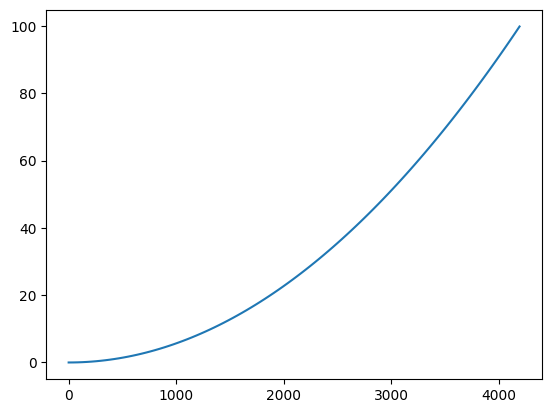

In [73]:
plt.plot(x0, z0)
plt.show()

In [74]:
q0=np.zeros(12*N)

In [75]:
for j in range(1,12):
    if j==1:
        q0[(j-1)*N:j*N]=x0
    elif j==5:
        q0[(j-1)*N:j*N]=z0

In [76]:
def static_func(Q): 
    t=0

    x,y,z=Q[0:N],Q[2*N:3*N],Q[4*N:5*N]
    dx,dy,dz=Q[1*N:2*N],Q[3*N:4*N],Q[5*N:6*N]
    φ,θ,ψ=Q[6*N:7*N],Q[8*N:9*N],Q[10*N:11*N]
    dφ,dθ,dψ=Q[7*N:8*N],Q[9*N:10*N],Q[11*N:12*N]
    
    RET = Ret(φ,θ,ψ)

    η = [x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]

    tau_force = np.array([-Fx_0,Fy_0,0,0,0,0])

    Z0 = tau_force[:3]    
    Z1 = d_s(ne, x, y, z, φ, θ, ψ).T
    Z2 = ne_hat(x, y, z, dx, dy, dz).T


    Z = (Z1 + Z2 - Z0)


############################################################
    ddx,ddy, ddz = (Z/Ws[0]).T
############################################################
    
    C0 = np.einsum('ijk,kp->ijp', Π(φ,θ,ψ), tau_force[3:].reshape(3,1))
    C1 = d_s(me, φ, θ, ψ, φ, θ, ψ)
    C = (C1.T - C0.squeeze())
 
    A0 = Jrho(RET,Jrho0)
    A_fin = np.einsum('ijk,ikr->ijr',A0, Π(φ,θ,ψ))

    B = np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ), np.stack((dφ,dθ,dψ), axis=1))
    
    D = w_e(φ,θ,ψ,dφ,dθ,dψ)
    
    G = np.cross(d_s(phi,x,y,z,φ, θ, ψ).T, ne(x, y, z, φ, θ, ψ))
    L = np.einsum('ijk,ik->ij',RET, (DR@D.T).T) 
    
    H = np.cross(D,np.einsum('ijk,ik->ij', A0, D))

#############################################
    ddφ,ddθ,ddψ = np.linalg.solve(A_fin, C + G - L - H - np.einsum('ijk,ik->ij',A0, B)).T
#############################################

    ans=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)

    return ans

In [77]:
root_ = root(static_func, q0, method='df-sane')

In [78]:
root_

 message: too many function evaluations required
 success: False
     fun: [ 1.203e+02  1.203e+02 ...  0.000e+00  0.000e+00]
       x: [ 2.205e+03  2.248e+03 ...  0.000e+00  0.000e+00]
     nit: 456
    nfev: 1000
  method: df-sane

In [79]:
x0_, z0_=root_.x[:N],root_.x[4*N:5*N]

In [80]:
# q0 = root_.x                                            # start from static solution

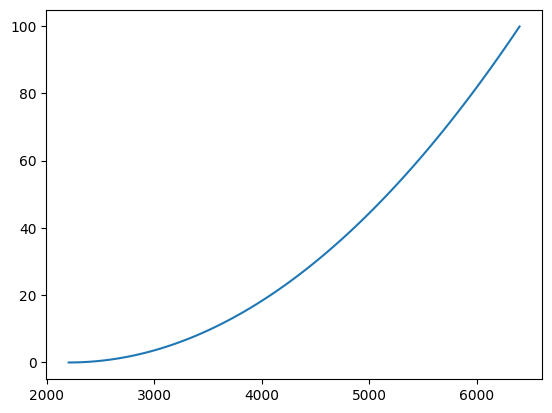

In [81]:
plt.plot(x0_, z0_)
plt.show()

### Finite Element Model of the Space Frame Element

In [82]:
def PlaneTrussElementLength(x1,y1,z1,x2,y2,z2):
    return np.sqrt((x2-x1)*(x2-x1) + (y2-y1)*(y2-y1)+(z2-z1)*(z2-z1))

In [83]:
def SpaceFrameElementStiffness(E,G,A,Iy,Iz,J,x1,y1,z1,x2,y2,z2):
    L = PlaneTrussElementLength(x1,y1,z1,x2,y2,z2)
    w1 = E*A/L
    w2 = 12*E*Iz/(L*L*L)
    w3 = 6*E*Iz/(L*L)
    w4 = 4*E*Iz/L
    w5 = 2*E*Iz/L
    w6 = 12*E*Iy/(L*L*L)
    w7 = 6*E*Iy/(L*L)
    w8 = 4*E*Iy/L
    w9 = 2*E*Iy/L
    w10 = G*J/L

    kprime = np.array([[w1, 0, 0, 0, 0, 0, -w1, 0, 0, 0, 0, 0],
                        [0, w2, 0, 0, 0, w3, 0, -w2, 0, 0, 0, w3],
                        [0, 0, w6, 0, -w7, 0, 0, 0, -w6, 0, -w7, 0],
                        [0, 0, 0, w10, 0, 0, 0, 0, 0, -w10, 0, 0],
                        [0, 0, -w7, 0, w8, 0, 0, 0, w7, 0, w9, 0],
                        [0, w3, 0, 0, 0, w4, 0, -w3, 0, 0, 0, w5],
                        [-w1, 0, 0, 0, 0, 0, w1, 0, 0, 0, 0, 0],
                        [0, -w2, 0, 0, 0, -w3, 0, w2, 0, 0, 0, -w3],
                        [0, 0, -w6, 0, w7, 0, 0, 0, w6, 0, w7, 0],
                        [0, 0, 0, -w10, 0, 0, 0, 0, 0, w10, 0, 0],
                        [0, 0, -w7, 0, w9, 0, 0, 0, w7, 0, w8, 0],
                        [0, w3, 0, 0, 0, w5, 0, -w3, 0, 0, 0, w4]])


    if x1 == x2 and y1 == y2:
        if z2 > z1:
            Lambda = np.array([[0, 0, 1], [0, 1, 0], [-1, 0, 0]])
        else:
            Lambda = np.array([[0, 0, -1], [0, 1, 0], [1, 0, 0]])
    else:
        CXx = (x2-x1)/L
        CYx = (y2-y1)/L
        CZx = (z2-z1)/L
        D = np.sqrt(CXx*CXx + CYx*CYx)
        CXy = -CYx/D
        CYy = CXx/D
        CZy = 0
        CXz = -CXx*CZx/D
        CYz = -CYx*CZx/D
        CZz = D
        Lambda = np.array([[CXx, CYx, CZx], [CXy, CYy, CZy], [CXz, CYz, CZz]])


    R = np.array([np.concatenate((np.concatenate((Lambda,np.zeros((3,3)),np.zeros((3,3)),np.zeros((3,3))),axis=1),
        np.concatenate((np.zeros((3,3)), Lambda, np.zeros((3,3)), np.zeros((3,3))),axis=1) ,
        np.concatenate((np.zeros((3,3)), np.zeros((3,3)), Lambda, np.zeros((3,3))),axis=1),
        np.concatenate((np.zeros((3,3)), np.zeros((3,3)), np.zeros((3,3)), Lambda),axis=1)))])[0]
    return np.dot(np.dot(R.T,kprime),R)

In [84]:
def SpaceFrameAssemble(K,k,i,j):
    K[6*i,6*i] = K[6*i,6*i] + k[0,0]
    K[6*i,6*i+1] = K[6*i,6*i+1] + k[0,1]
    K[6*i,6*i+2] = K[6*i,6*i+2] + k[0,2]
    K[6*i,6*i+3] = K[6*i,6*i+3] + k[0,3]
    K[6*i,6*i+4] = K[6*i,6*i+4] + k[0,4]
    K[6*i,6*i+5] = K[6*i,6*i+5] + k[0,5]
    K[6*i,6*j] = K[6*i,6*j] + k[0,6]
    K[6*i,6*j+1] = K[6*i,6*j+1] + k[0,7]
    K[6*i,6*j+2] = K[6*i,6*j+2] + k[0,8]
    K[6*i,6*j+3] = K[6*i,6*j+3] + k[0,9]
    K[6*i,6*j+4] = K[6*i,6*j+4] + k[0,10]
    K[6*i,6*j+5] = K[6*i,6*j+5] + k[0,11]
    K[6*i+1,6*i] = K[6*i+1,6*i] + k[1,0]
    K[6*i+1,6*i+1] = K[6*i+1,6*i+1] + k[1,1]
    K[6*i+1,6*i+2] = K[6*i+1,6*i+2] + k[1,2]
    K[6*i+1,6*i+3] = K[6*i+1,6*i+3] + k[1,3]
    K[6*i+1,6*i+4] = K[6*i+1,6*i+4] + k[1,4]
    K[6*i+1,6*i+5] = K[6*i+1,6*i+5] + k[1,5]
    K[6*i+1,6*j] = K[6*i+1,6*j] + k[1,6]
    K[6*i+1,6*j+1] = K[6*i+1,6*j+1] + k[1,7]
    K[6*i+1,6*j+2] = K[6*i+1,6*j+2] + k[1,8]
    K[6*i+1,6*j+3] = K[6*i+1,6*j+3] + k[1,9]
    K[6*i+1,6*j+4] = K[6*i+1,6*j+4] + k[1,10]
    K[6*i+1,6*j+5] = K[6*i+1,6*j+5] + k[1,11]
    K[6*i+2,6*i]   = K[6*i+2,6*i] + k[2,0]
    K[6*i+2,6*i+1] = K[6*i+2,6*i+1] + k[2,1]
    K[6*i+2,6*i+2] = K[6*i+2,6*i+2] + k[2,2]
    K[6*i+2,6*i+3] = K[6*i+2,6*i+3] + k[2,3]
    K[6*i+2,6*i+4] = K[6*i+2,6*i+4] + k[2,4]
    K[6*i+2,6*i+5] = K[6*i+2,6*i+5] + k[2,5]
    K[6*i+2,6*j]   = K[6*i+2,6*j] + k[2,6]
    K[6*i+2,6*j+1] = K[6*i+2,6*j+1] + k[2,7]
    K[6*i+2,6*j+2] = K[6*i+2,6*j+2] + k[2,8]
    K[6*i+2,6*j+3] = K[6*i+2,6*j+3] + k[2,9]
    K[6*i+2,6*j+4] = K[6*i+2,6*j+4] + k[2,10]
    K[6*i+2,6*j+5] = K[6*i+2,6*j+5] + k[2,11]
    K[6*i+3,6*i] = K[6*i+3,6*i] + k[3,0]
    K[6*i+3,6*i+1] = K[6*i+3,6*i+1] + k[3,1]
    K[6*i+3,6*i+2] = K[6*i+3,6*i+2] + k[3,2]
    K[6*i+3,6*i+3] = K[6*i+3,6*i+3] + k[3,3]
    K[6*i+3,6*i+4] = K[6*i+3,6*i+4] + k[3,4]
    K[6*i+3,6*i+5] = K[6*i+3,6*i+5] + k[3,5]
    K[6*i+3,6*j] = K[6*i+3,6*j] + k[3,6]
    K[6*i+3,6*j+1] = K[6*i+3,6*j+1] + k[3,7]
    K[6*i+3,6*j+2] = K[6*i+3,6*j+2] + k[3,8]
    K[6*i+3,6*j+3] = K[6*i+3,6*j+3] + k[3,9]
    K[6*i+3,6*j+4] = K[6*i+3,6*j+4] + k[3,10]
    K[6*i+3,6*j+5] = K[6*i+3,6*j+5] + k[3,11]
    K[6*i+4,6*i] = K[6*i+4,6*i] + k[4,0]
    K[6*i+4,6*i+1] = K[6*i+4,6*i+1] + k[4,1]
    K[6*i+4,6*i+2] = K[6*i+4,6*i+2] + k[4,2]
    K[6*i+4,6*i+3] = K[6*i+4,6*i+3] + k[4,3]
    K[6*i+4,6*i+4] = K[6*i+4,6*i+4] + k[4,4]
    K[6*i+4,6*i+5] = K[6*i+4,6*i+5] + k[4,5]
    K[6*i+4,6*j] = K[6*i+4,6*j] + k[4,6]
    K[6*i+4,6*j+1] = K[6*i+4,6*j+1] + k[4,7]
    K[6*i+4,6*j+2] = K[6*i+4,6*j+2] + k[4,8]
    K[6*i+4,6*j+3] = K[6*i+4,6*j+3] + k[4,9]
    K[6*i+4,6*j+4] = K[6*i+4,6*j+4] + k[4,10]
    K[6*i+4,6*j+5] = K[6*i+4,6*j+5] + k[4,11]
    K[6*i+5,6*i] = K[6*i+5,6*i] + k[5,0]
    K[6*i+5,6*i+1] = K[6*i+5,6*i+1] + k[5,1]
    K[6*i+5,6*i+2] = K[6*i+5,6*i+2] + k[5,2]
    K[6*i+5,6*i+3] = K[6*i+5,6*i+3] + k[5,3]
    K[6*i+5,6*i+4] = K[6*i+5,6*i+4] + k[5,4]
    K[6*i+5,6*i+5] = K[6*i+5,6*i+5] + k[5,5]
    K[6*i+5,6*j] = K[6*i+5,6*j] + k[5,6]
    K[6*i+5,6*j+1] = K[6*i+5,6*j+1] + k[5,7]
    K[6*i+5,6*j+2] = K[6*i+5,6*j+2] + k[5,8]
    K[6*i+5,6*j+3] = K[6*i+5,6*j+3] + k[5,9]
    K[6*i+5,6*j+4] = K[6*i+5,6*j+4] + k[5,10]
    K[6*i+5,6*j+5] = K[6*i+5,6*j+5] + k[5,11]
    K[6*j,6*i] = K[6*j,6*i] + k[6,0]
    K[6*j,6*i+1] = K[6*j,6*i+1] + k[6,1]
    K[6*j,6*i+2] = K[6*j,6*i+2] + k[6,2]
    K[6*j,6*i+3] = K[6*j,6*i+3] + k[6,3]
    K[6*j,6*i+4] = K[6*j,6*i+4] + k[6,4]
    K[6*j,6*i+5] = K[6*j,6*i+5] + k[6,5]
    K[6*j,6*j] = K[6*j,6*j] + k[6,6]
    K[6*j,6*j+1] = K[6*j,6*j+1] + k[6,7]
    K[6*j,6*j+2] = K[6*j,6*j+2] + k[6,8]
    K[6*j,6*j+3] = K[6*j,6*j+3] + k[6,9]
    K[6*j,6*j+4] = K[6*j,6*j+4] + k[6,10]
    K[6*j,6*j+5] = K[6*j,6*j+5] + k[6,11]
    K[6*j+1,6*i] = K[6*j+1,6*i] + k[7,0]
    K[6*j+1,6*i+1] = K[6*j+1,6*i+1] + k[7,1]
    K[6*j+1,6*i+2] = K[6*j+1,6*i+2] + k[7,2]
    K[6*j+1,6*i+3] = K[6*j+1,6*i+3] + k[7,3]
    K[6*j+1,6*i+4] = K[6*j+1,6*i+4] + k[7,4]
    K[6*j+1,6*i+5] = K[6*j+1,6*i+5] + k[7,5]
    K[6*j+1,6*j] = K[6*j+1,6*j] + k[7,6]
    K[6*j+1,6*j+1] = K[6*j+1,6*j+1] + k[7,7]
    K[6*j+1,6*j+2] = K[6*j+1,6*j+2] + k[7,8]
    K[6*j+1,6*j+3] = K[6*j+1,6*j+3] + k[7,9]
    K[6*j+1,6*j+4] = K[6*j+1,6*j+4] + k[7,10]
    K[6*j+1,6*j+5] = K[6*j+1,6*j+5] + k[7,11]
    K[6*j+2,6*i] = K[6*j+2,6*i] + k[8,0]
    K[6*j+2,6*i+1] = K[6*j+2,6*i+1] + k[8,1]
    K[6*j+2,6*i+2] = K[6*j+2,6*i+2] + k[8,2]
    K[6*j+2,6*i+3] = K[6*j+2,6*i+3] + k[8,3]
    K[6*j+2,6*i+4] = K[6*j+2,6*i+4] + k[8,4]
    K[6*j+2,6*i+5] = K[6*j+2,6*i+5] + k[8,5]
    K[6*j+2,6*j] = K[6*j+2,6*j] + k[8,6]
    K[6*j+2,6*j+1] = K[6*j+2,6*j+1] + k[8,7]
    K[6*j+2,6*j+2] = K[6*j+2,6*j+2] + k[8,8]
    K[6*j+2,6*j+3] = K[6*j+2,6*j+3] + k[8,9]
    K[6*j+2,6*j+4] = K[6*j+2,6*j+4] + k[8,10]
    K[6*j+2,6*j+5] = K[6*j+2,6*j+5] + k[8,11]
    K[6*j+3,6*i] = K[6*j+3,6*i] + k[9,0]
    K[6*j+3,6*i+1] = K[6*j+3,6*i+1] + k[9,1]
    K[6*j+3,6*i+2] = K[6*j+3,6*i+2] + k[9,2]
    K[6*j+3,6*i+3] = K[6*j+3,6*i+3] + k[9,3]
    K[6*j+3,6*i+4] = K[6*j+3,6*i+4] + k[9,4]
    K[6*j+3,6*i+5] = K[6*j+3,6*i+5] + k[9,5]
    K[6*j+3,6*j] = K[6*j+3,6*j] + k[9,6]
    K[6*j+3,6*j+1] = K[6*j+3,6*j+1] + k[9,7]
    K[6*j+3,6*j+2] = K[6*j+3,6*j+2] + k[9,8]
    K[6*j+3,6*j+3] = K[6*j+3,6*j+3] + k[9,9]
    K[6*j+3,6*j+4] = K[6*j+3,6*j+4] + k[9,10]
    K[6*j+3,6*j+5] = K[6*j+3,6*j+5] + k[9,11]
    K[6*j+4,6*i] = K[6*j+4,6*i] + k[10,0]
    K[6*j+4,6*i+1] = K[6*j+4,6*i+1] + k[10,1]
    K[6*j+4,6*i+2] = K[6*j+4,6*i+2] + k[10,2]
    K[6*j+4,6*i+3] = K[6*j+4,6*i+3] + k[10,3]
    K[6*j+4,6*i+4] = K[6*j+4,6*i+4] + k[10,4]
    K[6*j+4,6*i+5] = K[6*j+4,6*i+5] + k[10,5]
    K[6*j+4,6*j] = K[6*j+4,6*j] + k[10,6]
    K[6*j+4,6*j+1] = K[6*j+4,6*j+1] + k[10,7]
    K[6*j+4,6*j+2] = K[6*j+4,6*j+2] + k[10,8]
    K[6*j+4,6*j+3] = K[6*j+4,6*j+3] + k[10,9]
    K[6*j+4,6*j+4] = K[6*j+4,6*j+4] + k[10,10]
    K[6*j+4,6*j+5] = K[6*j+4,6*j+5] + k[10,11]
    K[6*j+5,6*i] = K[6*j+5,6*i] + k[11,0]
    K[6*j+5,6*i+1] = K[6*j+5,6*i+1] + k[11,1]
    K[6*j+5,6*i+2] = K[6*j+5,6*i+2] + k[11,2]
    K[6*j+5,6*i+3] = K[6*j+5,6*i+3] + k[11,3]
    K[6*j+5,6*i+4] = K[6*j+5,6*i+4] + k[11,4]
    K[6*j+5,6*i+5] = K[6*j+5,6*i+5] + k[11,5]
    K[6*j+5,6*j] = K[6*j+5,6*j] + k[11,6]
    K[6*j+5,6*j+1] = K[6*j+5,6*j+1] + k[11,7]
    K[6*j+5,6*j+2] = K[6*j+5,6*j+2] + k[11,8]
    K[6*j+5,6*j+3] = K[6*j+5,6*j+3] + k[11,9]
    K[6*j+5,6*j+4] = K[6*j+5,6*j+4] + k[11,10]
    K[6*j+5,6*j+5] = K[6*j+5,6*j+5] + k[11,11]

    return K

In [85]:
def FEA(coord, elcon, bc_node, bc_val, vessel_movement, coefs,
          E=210e6, G=84e6, A=2e-2, Iy=10e-5, Iz=20e-5, J=5e-5):

    coord=np.array(coord)
    elcon=np.array(elcon)

    K=np.zeros(shape=(6*(np.max(elcon)+1),6*(np.max(elcon)+1)))

    for el in elcon:
        k=SpaceFrameElementStiffness(E,G,A,Iy,Iz,J,
                                     coord[el[0]][0],coord[el[0]][1],coord[el[0]][2],\
                                     coord[el[1]][0],coord[el[1]][1],coord[el[1]][2])
        K=SpaceFrameAssemble(K,k,el[0],el[1])
        
        
    glob_force=np.dot(K, np.array(vessel_movement))
    
    glob_force[-6:]=np.multiply(glob_force[-6:], coefs)
    glob_force = np.zeros(len(vessel_movement))


    F=np.zeros(len(coord)*6)
    for i in range(len(vessel_movement)):
        if vessel_movement[i]:
            F[i]=glob_force[i]

    # https://github.com/CALFEM/calfem-matlab/blob/master/fem/solveq.m

    bc=np.array([bc_node,
                bc_val]).T
    nd, nd=K.shape
    fdof=np.array([i for i in range(nd)]).T
    d=np.zeros(shape=(len(fdof),))
    Q=np.zeros(shape=(len(fdof),))

    pdof=bc[:,0].astype(int)
    dp=bc[:,1]
    fdof=np.delete(fdof, pdof, 0)
    s=scipy.linalg.lstsq(K[fdof,:][:,fdof], (F[fdof].T-np.dot(K[fdof,:][:,pdof],dp.T)).T, check_finite=True)[0]
    d[pdof]=dp
    d[fdof]=s.reshape(-1,)
    

#     Q=np.dot(K,d).T-F
    return d, np.dot(K,d).T

In [86]:
# 10 The Space Frame Element - verification
d,f=FEA(np.array([0,0,0,
                  3,0,0,
                  0,0,-3,
                  0,-4,0]).reshape(4,3),
        elcon=np.array([[0, 1],
                      [0, 2],
                      [0, 3]]),
        bc_node=list(range(6)),
        bc_val=[ -0.0705e-4, -0.0007e-4, 0.1418e-4, 0.0145e-4, 0.0175e-4,0.0114e-4],
        vessel_movement=[ 0, 0, 0, 0, 0,0.0,
                                0,0,0,0,0,0,
                                0,0,0,0,0,0,
                                0,0,0,0,0,0,
                       ],
        coefs=[1,1,1,1,1,1])

In [87]:
d

array([-7.050e-06, -7.000e-08,  1.418e-05,  1.450e-06,  1.750e-06,
        1.140e-06, -7.050e-06,  3.350e-06,  8.930e-06,  1.450e-06,
        1.750e-06,  1.140e-06, -1.230e-05,  4.280e-06,  1.418e-05,
        1.450e-06,  1.750e-06,  1.140e-06, -2.490e-06, -7.000e-08,
        8.380e-06,  1.450e-06,  1.750e-06,  1.140e-06])

In [88]:
f

array([ 2.18575158e-15, -1.86923231e-17, -3.84067778e-15,  9.71445147e-17,
        4.94078553e-17, -1.38777878e-17, -5.59719372e-16, -2.94360890e-17,
        2.29749217e-17,  3.06625927e-19,  2.51331616e-17,  5.88721780e-17,
        1.93123512e-17,  1.42708111e-17,  1.72398987e-15, -2.85416222e-17,
        6.63802780e-17, -6.09863722e-20,  2.08166817e-17,  4.64478987e-17,
        2.42861287e-17,  1.38777878e-17,  3.17637355e-20, -1.38777878e-17])

In [89]:
def PipeForce(X,Y,Z,vessel_movement,coefs, E=210e6, G=84e6,  
              A=Ar, Iy=39.4925/7860, Iz=39.4925/7860, J=1.0062*1e-2,
#               A=2e-2, Iy=10e-5, Iz=20e-5, J=5e-5
             ):
    coord=np.stack((X,Y,Z)).T
    elcon=[]
    for i in range(1,len(X)):
        elcon.append([i-1,i])

#     bc_node = list(range(6))+list(range((len(X)-6),len(X)))
#     bc_val = [0]*6 + vessel_movement
    
    bc_node = list(range(3))+list(range((len(X)-6),len(X)))
    bc_val = [0]*3 + vessel_movement

    vessel_move=np.zeros(len(X)*6)
#     vessel_move[-6:]=vessel_movement

    d,f=FEA(coord,elcon,bc_node,bc_val,vessel_move, coefs, E,G,A,Iy,Iz,J)

    fors=[]
    for i in range(0,len(f),6):
        fors.append(f[i:i+3])

    mom =[]
    for i in range(3,len(f),6):
        mom.append(f[i:i+3])

    angle=[]
    for i in range(3,len(d),6):
        angle.append(d[i:i+3])
    fors[0][0]=0
    fors[0][1]=0
    fors[0][2]=0
    return np.array(fors), np.array(mom), np.array(angle)

In [90]:
fors, mom, angle = PipeForce(x0_,list([0 for i in range(len(z0))]),z0_,
[0.01,
 0.02,
 0.03,
 0.01,
 -0.05,
 0.03],
 [1,1,1,1,1,1]
)

In [91]:
fors

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-7.50446816e-10,  2.29485408e-09, -8.56175575e-10],
       [ 6.38010533e-10,  2.27913688e-10,  1.79295512e-09],
       [ 1.26703981e-09,  1.01190234e-09, -1.41540113e-10],
       [ 1.07334586e-09,  3.81305654e-09,  4.24108748e-10],
       [-1.29875843e-09, -1.38004452e-09, -5.86624083e-11],
       [-1.55341695e-09, -4.98516783e-10, -1.02249942e-09],
       [-4.85670171e-10,  2.35242681e-09, -1.02386366e-09],
       [-2.18574314e-09, -1.80705229e-09,  5.29430721e-10],
       [-2.69119482e-09, -2.82693691e-09,  4.67935024e-10],
       [ 1.03682396e-10, -5.16706677e-10, -1.10981091e-09],
       [-3.14685167e-10,  1.65765057e-09, -2.47837306e-11],
       [ 1.71348802e-09,  6.77573553e-11,  1.94090610e-09],
       [-1.12595444e-09, -7.82279130e-10, -1.02106412e-09],
       [-1.81216819e-10,  3.71699116e-10,  2.00310524e-09],
       [-6.47105480e-10, -2.28309349e-09,  1.03966613e-09],
       [ 2.77615446e+02, -1.66069298e-01

In [92]:
mom

array([[-4.14748291e-10,  9.27797730e-10, -8.73797035e-10],
       [-3.98586053e-10,  1.11867848e-10,  2.56999533e-10],
       [-4.01996658e-10, -1.79318249e-09,  3.05135472e-10],
       [-3.98244993e-10,  2.81943358e-10, -4.28826752e-10],
       [-3.96534361e-10,  3.79964149e-09,  7.26686267e-10],
       [-3.52429197e-10, -2.08092388e-09, -7.20013382e-10],
       [-3.12411430e-10, -8.84297080e-11,  2.25554686e-10],
       [ 9.05743036e-10, -2.85581336e-10,  3.23325366e-10],
       [ 2.58111754e-10,  3.89847266e-10, -5.98447514e-10],
       [ 2.59888111e-10, -1.22781785e-09,  4.23883151e-10],
       [-8.63565219e-10,  1.66187419e-09, -1.47338142e-10],
       [-3.71528586e-10, -2.33376340e-09,  8.04902811e-11],
       [ 6.23501251e-11,  4.96811481e-10,  1.64618541e-10],
       [-1.51658242e-10, -1.62026481e-09, -5.75210990e-10],
       [ 4.01769285e-10,  5.67752068e-10,  6.19365892e-10],
       [-1.05058007e-09, -1.57734240e+02,  1.12578027e+02],
       [-4.33328261e-01, -3.65503183e-11

In [93]:
angle

array([[ 0.03007837, -0.02185333, -0.01178184],
       [ 0.03007834, -0.02119938, -0.01164059],
       [ 0.0300782 , -0.01935112, -0.01121684],
       [ 0.03007786, -0.01653571, -0.01051059],
       [ 0.03007721, -0.01298031, -0.00952184],
       [ 0.03007616, -0.00891207, -0.00825058],
       [ 0.03007459, -0.00455817, -0.00669682],
       [ 0.03007241, -0.00014575, -0.00486055],
       [ 0.03006952,  0.00409801, -0.00274178],
       [ 0.03006581,  0.00794596, -0.0003405 ],
       [ 0.03006118,  0.01117092,  0.00234329],
       [ 0.03005553,  0.01354574,  0.0053096 ],
       [ 0.03004875,  0.01484323,  0.00855842],
       [ 0.03004075,  0.01483622,  0.01208976],
       [ 0.03003142,  0.01329754,  0.01590362],
       [ 0.03002066,  0.01      ,  0.02      ],
       [ 0.03      ,  0.01104993,  0.0198585 ],
       [ 0.03000001,  0.01105006,  0.01985828],
       [ 0.03000001,  0.01105018,  0.01985807],
       [ 0.03000002,  0.0110503 ,  0.01985787],
       [ 0.03000002,  0.01105042,  0.019

### Vessle Simulation

In [94]:
sampleTime = 0.001              # sample time [seconds]
Number = 100000                      # number of samples

In [95]:
Number*sampleTime

100.0

In [96]:
vehicle=semisub('DPcontrol',0.1,-0.1,40.0,0,0)

In [97]:
[simTime, simData] = simulate(Number, sampleTime, vehicle)

In [98]:
ans_t=[]
sum_=0
for i in range(simData.shape[0]):
    ans_t.append(sum_)
    sum_+=sampleTime

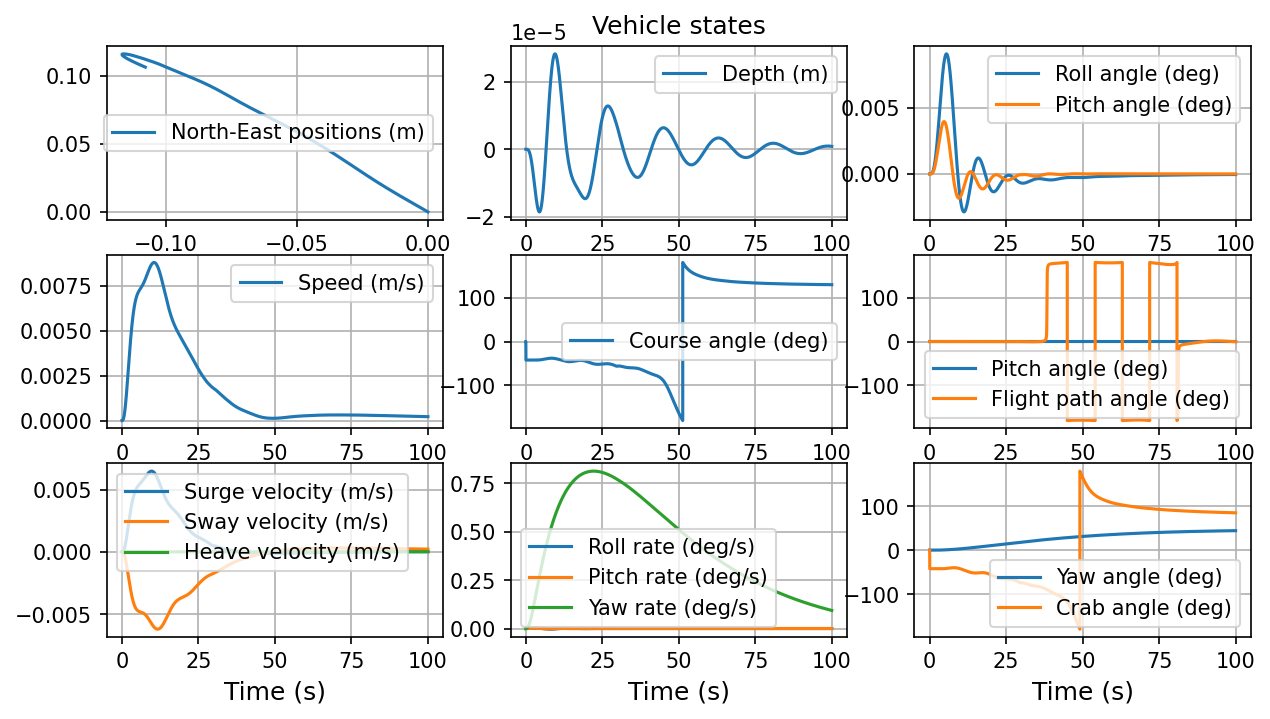

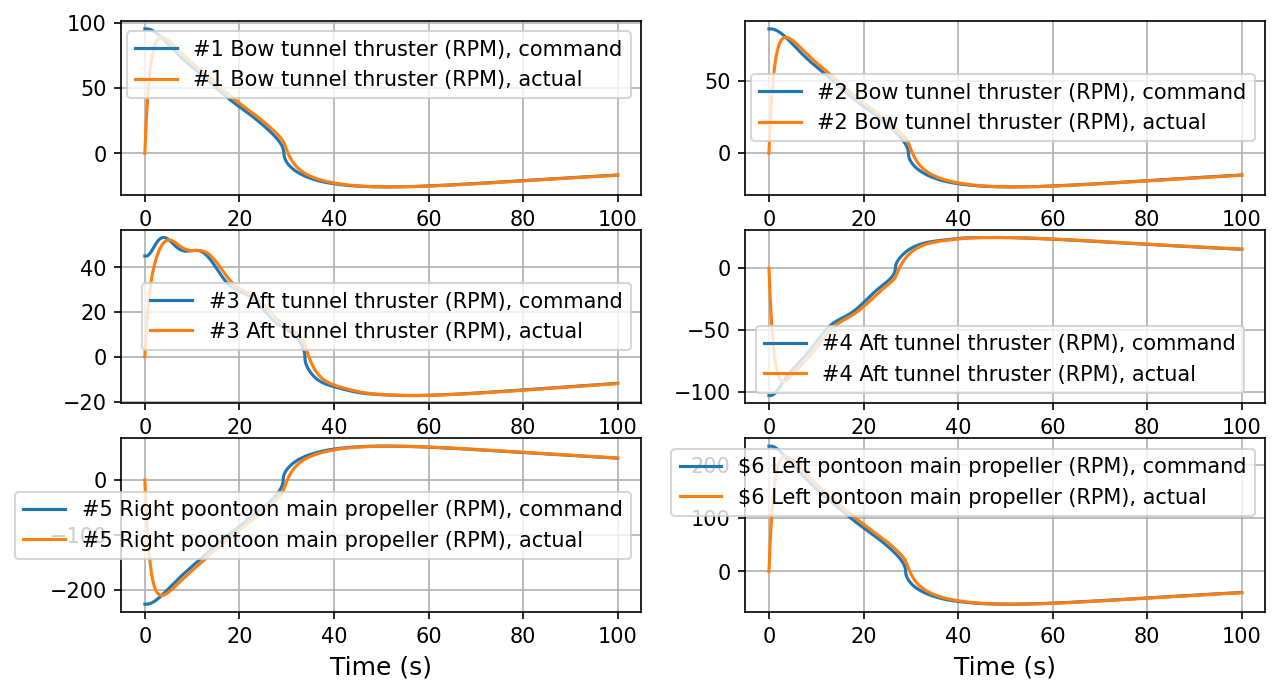

In [99]:
plotVehicleStates(simTime, simData, 1)
plotControls(simTime, simData, vehicle, 2)

In [100]:
numDataPoints = 5                 # number of 3D data points
FPS = 10                            # frames per second (animated GIF)
filename = '3D_animation.gif'       # data file for animated GIF
browser = 'safari'

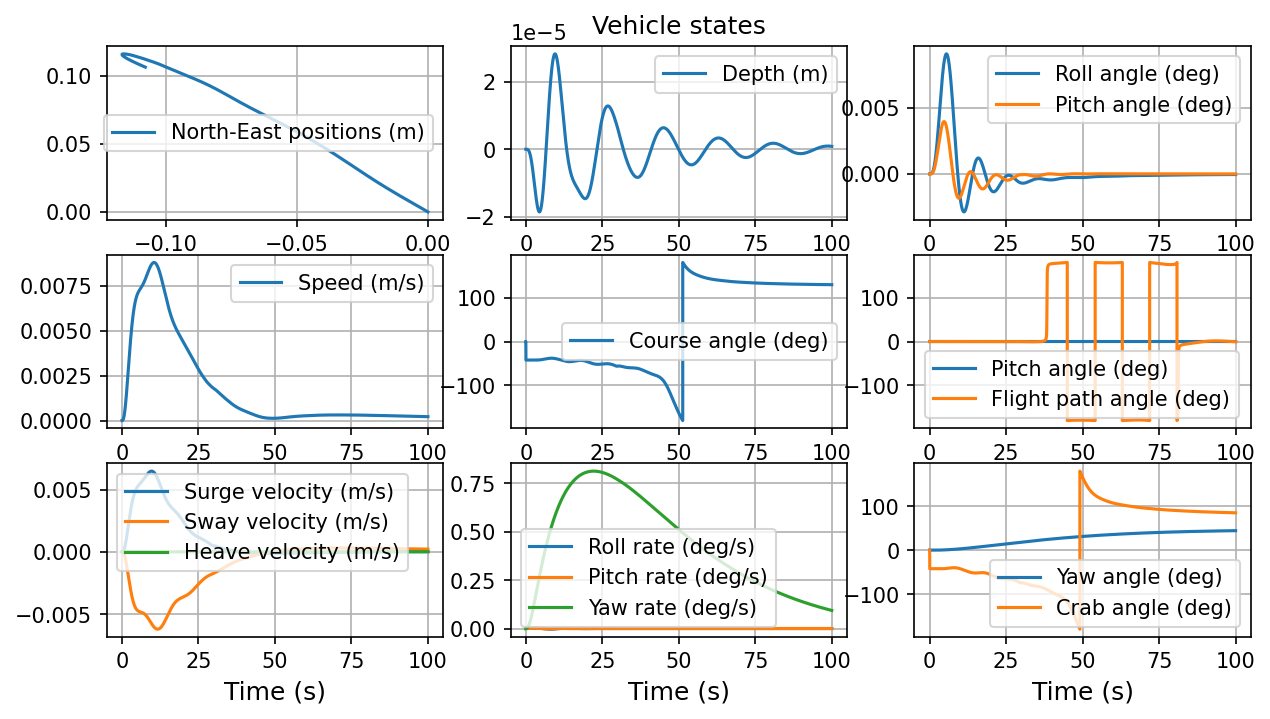

In [101]:
plotVehicleStates(simTime, simData, 3)

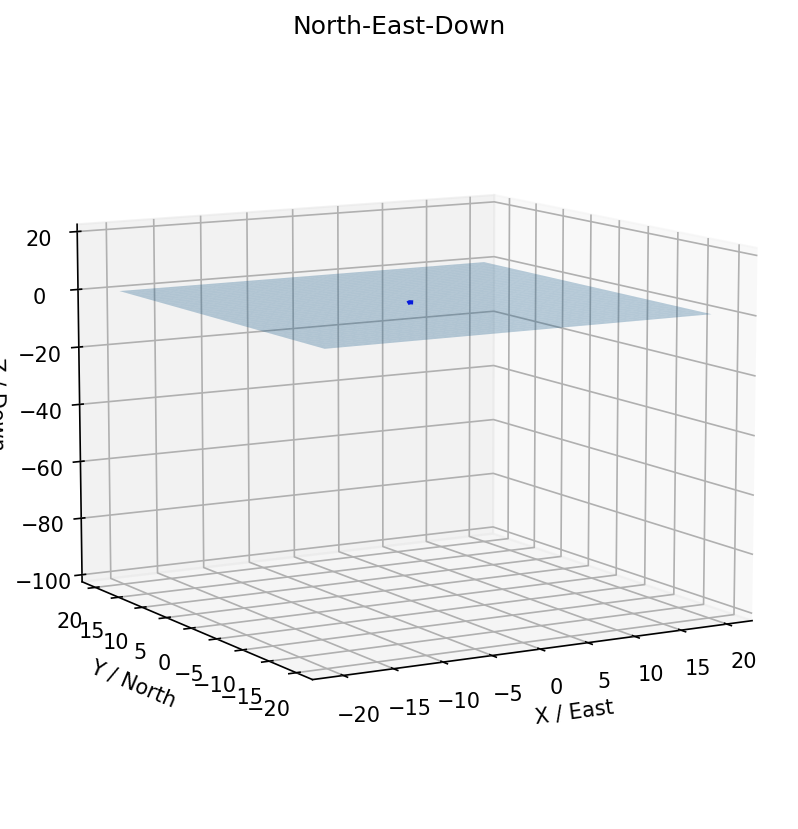

In [102]:
plot3D(simData, numDataPoints, FPS, filename, 3)

In [103]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [104]:
class MyTime:
    def __init__(self):
        self.my_t = 0
        self.v_m = np.array([0,0,0,0,0,0]).astype(np.float64)
        self.progression = [i for i in range(650)]
        self.wall_clock = datetime.now()
        self.x_ve = 0
        self.y_ve = 0
        self.z_ve = 0
        self.phi_ve = 0
        self.theta_ve = 0
        self.psi_ve = 0

In [105]:
def inert(M, m, X):
    sum_=M
    ans=[]
    for i in range(len(X)-1,-1,-1):
        sum_+=m
        ans.append(np.array(sum_).copy())
    return np.array(ans)  

In [106]:
V_rho=np.zeros(Jrho0.shape)
np.fill_diagonal(V_rho, vessel_inertia)

In [107]:
M_t=inert(vessel_mass*9.81,mp*9.81, x0)
Jrho1=inert(V_rho, Jrho0, x0)

### Dynamics

In [108]:
def dynamic_func(t, Q, coefs, T, calibr):
    
    x,y,z=Q[0:N],Q[2*N:3*N],Q[4*N:5*N]
    dx,dy,dz=Q[1*N:2*N],Q[3*N:4*N],Q[5*N:6*N]
    φ,θ,ψ=Q[6*N:7*N],Q[8*N:9*N],Q[10*N:11*N]
    dφ,dθ,dψ=Q[7*N:8*N],Q[9*N:10*N],Q[11*N:12*N]
    
    idx = find_nearest(np.array(ans_t),  t)
    
    del_t = idx-T.my_t
    if del_t<0:
        idx=T.my_t
        
    x_ve = simData[:, 0][idx]
    y_ve = simData[:, 1][idx]
    z_ve = simData[:, 2][idx]
    phi_ve = ssa(simData[:, 3][idx])
    theta_ve = ssa(simData[:, 4][idx])
    psi_ve = ssa(simData[:, 5][idx])
    
    RET = Ret(φ,θ,ψ)

    vessel_movement = np.zeros(6)
    
    vessel_movement[0] = (x_ve - T.x_ve)
    vessel_movement[1] = (y_ve - T.y_ve)
    vessel_movement[2] = (z_ve - T.z_ve)
    vessel_movement[3] = np.radians(phi_ve - T.phi_ve)
    vessel_movement[4] = np.radians(theta_ve - T.theta_ve)
    vessel_movement[5] = np.radians(psi_ve - T.psi_ve)
    vessel_movement/=calibr
    
    fors, mom, angle = PipeForce(x, y, z, list(vessel_movement), coefs)
    
    Z0 = fors.squeeze()
    Z1 = d_s(ne, x, y, z, φ, θ, ψ).T
    Z2 = ne_hat(x, y, z, dx, dy, dz).T

    Z = (Z1 + Z2 - Z0)

############################################################
#     ddx,ddy, ddz = (Z/(M_t.reshape(-1, 1))).T
    ddx,ddy, ddz = (Z/Ws[0]).T    
############################################################
    
    C0 = np.einsum('ijk,ik->ij', Π(φ,θ,ψ), angle).squeeze()    
    C1 = d_s(me, φ, θ, ψ, φ, θ, ψ)
    C = (C1.T - C0)


    A0 = Jrho(RET,Jrho0)
#     A0 = Jrho(RET,Jrho1) 
    A_fin = np.einsum('ijk,ikr->ijr', A0, Π(φ,θ,ψ))
    

    B = np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ), np.stack((dφ,dθ,dψ), axis=1))
    
    D = w_e(φ,θ,ψ,dφ,dθ,dψ)
    
    G = np.cross(d_s(phi,x,y,z,φ, θ, ψ).T, ne(x, y, z, φ, θ, ψ))
    
    L = np.einsum('ijk,ik->ij',RET, (DR@D.T).T) 

    H = np.cross(D, np.einsum('ijk,ik->ij', A0, D))
    

#############################################
    ddφ,ddθ,ddψ = np.linalg.solve(A_fin, (C + G - L - H - np.einsum('ijk,ik->ij', A0, B))).T
#############################################

    T.my_t=idx
    T.x_ve=x_ve
    T.y_ve=y_ve
    T.z_ve=z_ve
    T.phi_ve = phi_ve
    T.theta_ve = theta_ve
    T.psi_ve = psi_ve

    if t>T.progression[0]:
        T.progression.pop(0)
        print('Physical time: ', t, ' Iteration wall clock time: ', datetime.now() - T.wall_clock )
        T.wall_clock = datetime.now()
        
    ans=np.concatenate([dx, ddx, 
                        dy, ddy, 
                        dz, ddz, 
                        dφ, ddφ, 
                        dθ, ddθ, 
                        dψ, ddψ
                       ], axis=0)
    
    return ans

In [109]:
# integration parameters
tspan = (0., 50)
T_ = MyTime()
coefs = [1, 1, 1, 1, 1, 1]

# initial conditions
q0[6*N:7*N], q0[8*N:9*N], q0[10*N:11*N] = (np.array([0.01 for i in range(N)]),
                                          np.array([0.000001 for i in range(N)]),
                                          np.array([0.000236*i/N for i in range(N)]))

In [110]:
vessel_motion_calibration_coefficient =1

In [111]:
startTime1 = datetime.now()
us_=solve_ivp(dynamic_func,
             tspan,
             q0,
             args=(coefs, T_, vessel_motion_calibration_coefficient,))
print(datetime.now() - startTime1)

Physical time:  1.7945925341564858e-07  Iteration wall clock time:  0:00:02.891370
Physical time:  1.0114232108493144  Iteration wall clock time:  0:00:55.192141
Physical time:  2.004966937980925  Iteration wall clock time:  0:00:48.934509
Physical time:  3.0142221954701816  Iteration wall clock time:  0:01:01.841095
Physical time:  4.015956335464942  Iteration wall clock time:  0:00:58.899801
Physical time:  5.055796517592909  Iteration wall clock time:  0:00:55.321046
Physical time:  6.00419233583227  Iteration wall clock time:  0:00:59.794090
Physical time:  7.022885893499707  Iteration wall clock time:  0:00:55.362525
Physical time:  8.012719611696012  Iteration wall clock time:  0:01:02.122143
Physical time:  9.019474727931401  Iteration wall clock time:  0:01:03.067117
Physical time:  10.006265411455178  Iteration wall clock time:  0:01:01.215945
Physical time:  11.009744669495806  Iteration wall clock time:  0:01:12.551984
Physical time:  12.0223538508378  Iteration wall clock t

### Results

In [112]:
fin=us_

In [113]:
fin

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.795e-05 ...  4.989e+01  5.000e+01]
        y: [[ 0.000e+00 -6.245e-26 ... -1.124e-02 -1.130e-02]
            [ 4.237e+01  4.237e+01 ...  4.239e+01  4.239e+01]
            ...
            [ 0.000e+00 -2.714e-19 ...  1.299e-08  1.234e-08]
            [ 0.000e+00  3.233e-20 ...  1.299e-08  1.234e-08]]
      sol: None
 t_events: None
 y_events: None
     nfev: 6218
     njev: 0
      nlu: 0

In [114]:
t=fin.t

In [115]:
fin=fin.y.T

In [116]:
t.shape, fin.shape

((712,), (712, 1200))

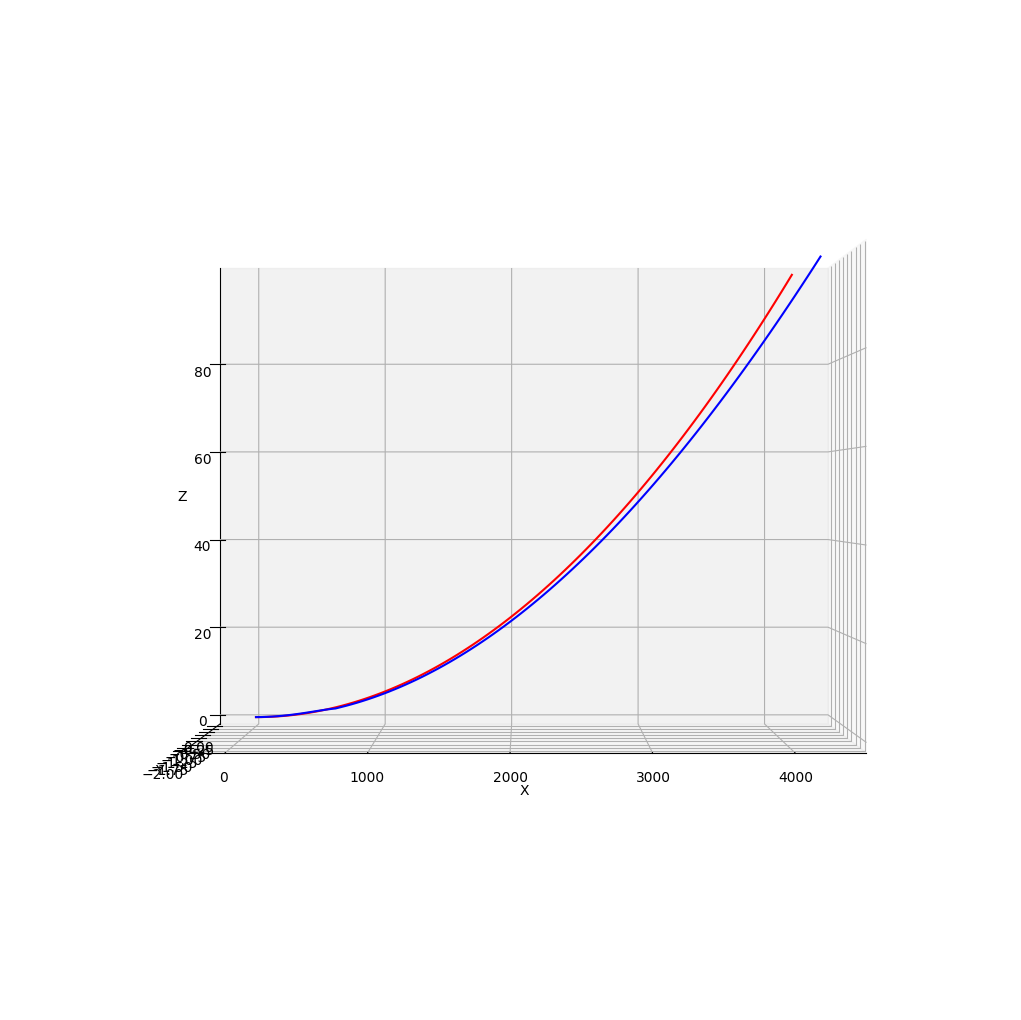

In [117]:
fig=plt.figure(figsize=(13,13))
ax = fig.add_subplot(projection = '3d')

X0=fin[0,[i for i in range(0,N)]]
Y0=fin[0,[i for i in range(2*N,3*N)]]
Z0=fin[0,[i for i in range(4*N,5*N)]]

j=-1
X=fin[j,[i for i in range(0,N)]]
Y=fin[j,[i for i in range(2*N,3*N)]]
Z=fin[j,[i for i in range(4*N,5*N)]]

num_true_pts = 200
tck, u = interpolate.splprep([X,Y,Z], s=2)
u_fine = np.linspace(0,1,num_true_pts)
x_fine, y_fine, z_fine = interpolate.splev(u_fine, tck)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b')
# ax.plot(x_fine, y_fine, z_fine, color='b')
# ax.view_init(-45,-45)
# ax.view_init(-30,-30)
ax.view_init(0,-90)
plt.show()

In [118]:
X,Y,Z

(array([-1.13027273e-02,  4.23931772e+01,  8.47932605e+01,  1.27189782e+02,
         1.69583614e+02,  2.11975355e+02,  2.54365431e+02,  2.96754154e+02,
         3.39141759e+02,  3.81528421e+02,  4.23914271e+02,  4.66299403e+02,
         5.08683888e+02,  5.51067776e+02,  5.93451119e+02,  6.35834020e+02,
         6.78253200e+02,  7.20597877e+02,  7.62979803e+02,  8.05361804e+02,
         8.47743931e+02,  8.90126225e+02,  9.32508723e+02,  9.74891448e+02,
         1.01727442e+03,  1.05965764e+03,  1.10204111e+03,  1.14442483e+03,
         1.18680878e+03,  1.22919294e+03,  1.27157729e+03,  1.31396180e+03,
         1.35634645e+03,  1.39873119e+03,  1.44111600e+03,  1.48350086e+03,
         1.52588575e+03,  1.56827063e+03,  1.61065548e+03,  1.65304029e+03,
         1.69542505e+03,  1.73780976e+03,  1.78019439e+03,  1.82257894e+03,
         1.86496336e+03,  1.90734764e+03,  1.94973176e+03,  1.99211571e+03,
         2.03449951e+03,  2.07688317e+03,  2.11926669e+03,  2.16165007e+03,
         2.2

In [119]:
X0,Y0,Z0

(array([   0.        ,   42.36605322,   84.73210644,  127.09815965,
         169.46421287,  211.83026609,  254.19631931,  296.56237252,
         338.92842574,  381.29447896,  423.66053218,  466.0265854 ,
         508.39263861,  550.75869183,  593.12474505,  635.49079827,
         677.85685149,  720.2229047 ,  762.58895792,  804.95501114,
         847.32106436,  889.68711757,  932.05317079,  974.41922401,
        1016.78527723, 1059.15133045, 1101.51738366, 1143.88343688,
        1186.2494901 , 1228.61554332, 1270.98159653, 1313.34764975,
        1355.71370297, 1398.07975619, 1440.44580941, 1482.81186262,
        1525.17791584, 1567.54396906, 1609.91002228, 1652.27607549,
        1694.64212871, 1737.00818193, 1779.37423515, 1821.74028837,
        1864.10634158, 1906.4723948 , 1948.83844802, 1991.20450124,
        2033.57055446, 2075.93660767, 2118.30266089, 2160.66871411,
        2203.03476733, 2245.40082054, 2287.76687376, 2330.13292698,
        2372.4989802 , 2414.86503342, 2457.23108

In [120]:
us=fin.T

In [121]:
us.shape

(1200, 712)

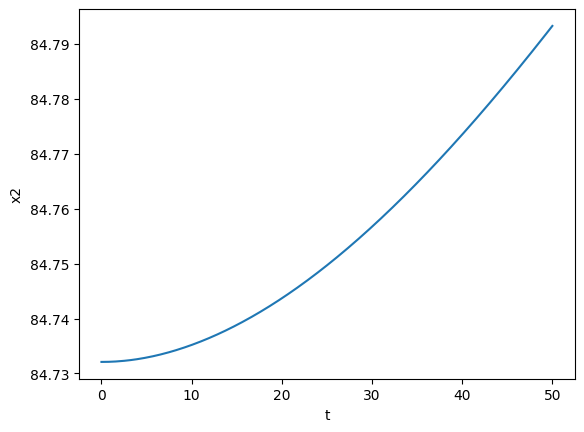

In [122]:
plt.plot(t,us.T[:,2],'-')
plt.xlabel('t')
plt.ylabel('x2')
plt.show()

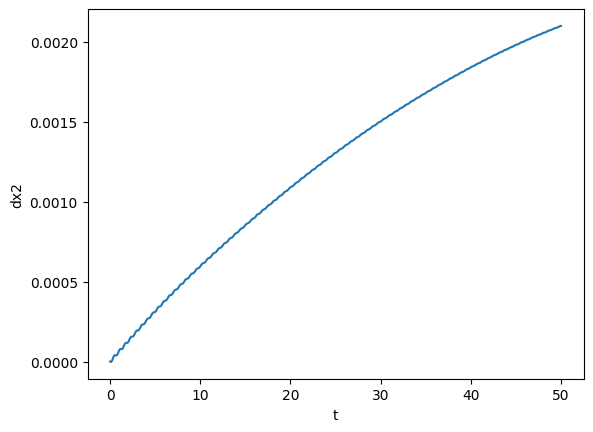

In [123]:
plt.plot(t,us.T[:,N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dx2')
plt.show()

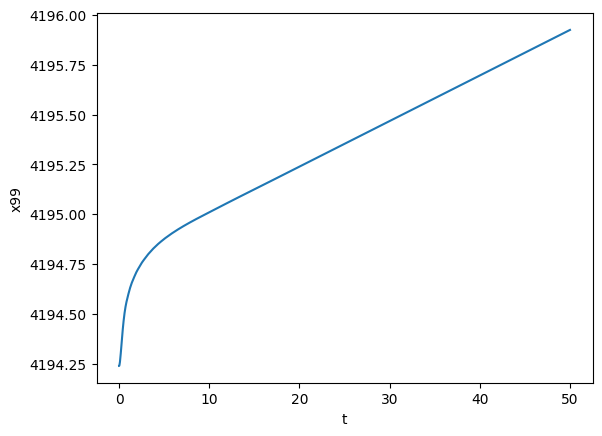

In [124]:
plt.plot(t,us.T[:,N-1] ,'-')
plt.xlabel('t')
plt.ylabel('x{}'.format(N-1))
plt.show()

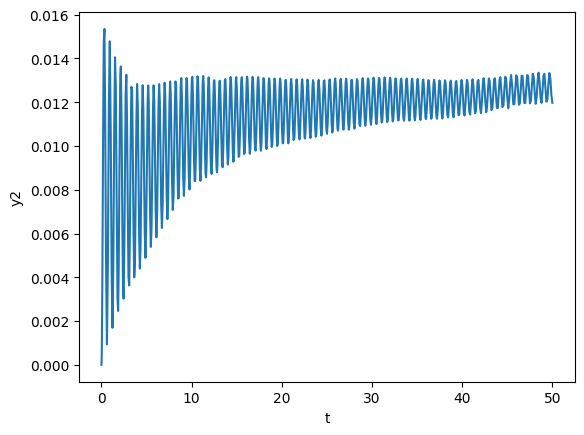

In [125]:
plt.plot(t,us.T[:,2*N +2] ,'-')
plt.xlabel('t')
plt.ylabel('y2')
plt.show()

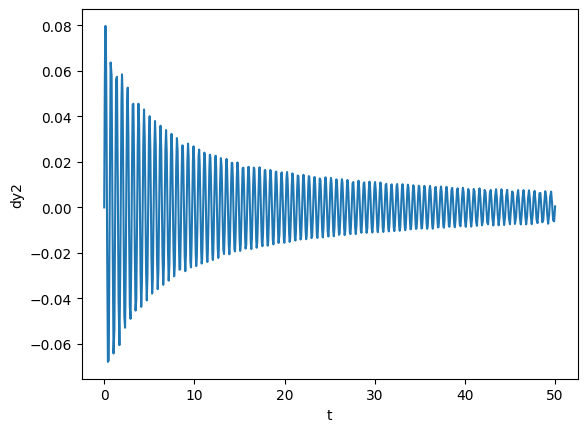

In [126]:
plt.plot(t,us.T[:,3*N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dy2')
plt.show()

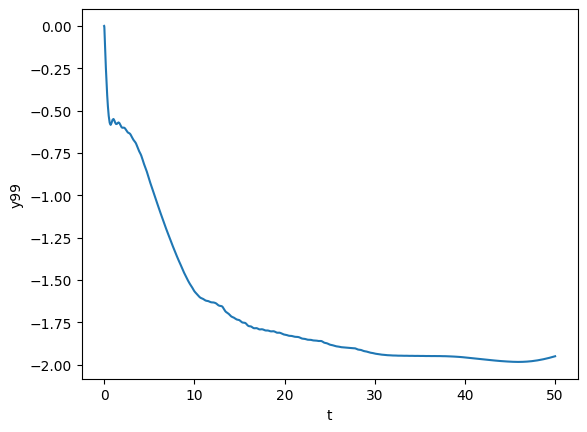

In [127]:
plt.plot(t,us.T[:,2*N+(N-1)] ,'-')
plt.xlabel('t')
plt.ylabel('y{}'.format(N-1))
plt.show()

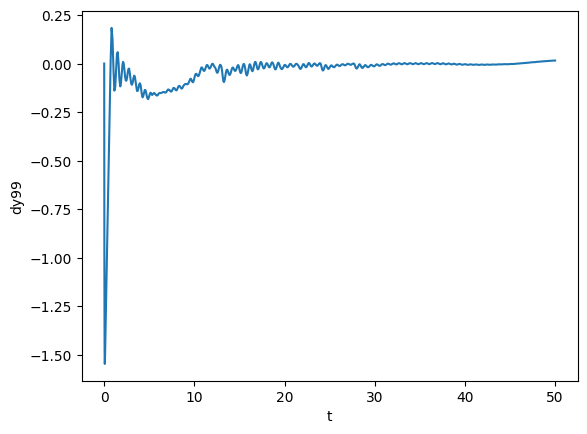

In [128]:
plt.plot(t,us.T[:,3*N+(N-1)] ,'-')
plt.xlabel('t')
plt.ylabel('dy{}'.format(N-1))
plt.show()

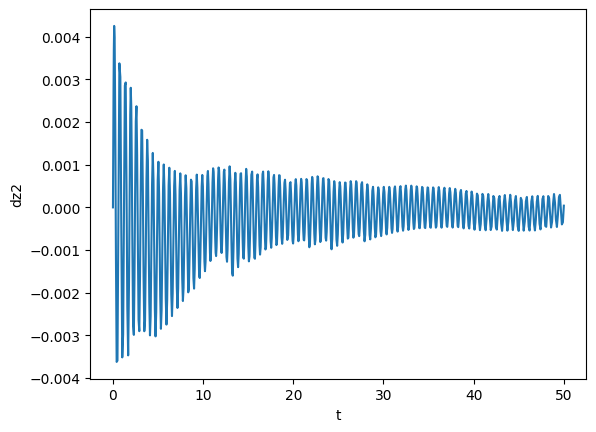

In [129]:
plt.plot(t,us.T[:,5*N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dz2')
plt.show()

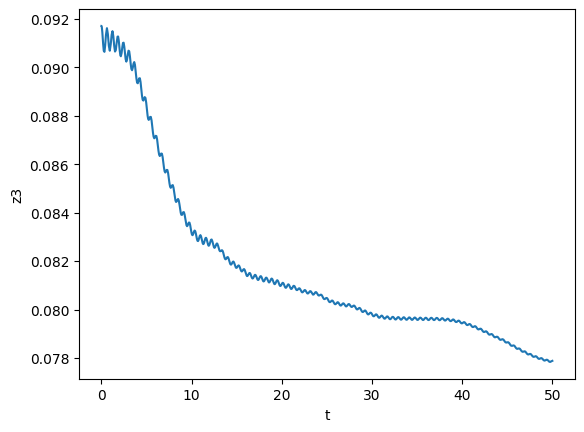

In [130]:
plt.plot(t,us.T[:,4*N+3] ,'-')
plt.xlabel('t')
plt.ylabel('z3')
plt.show()

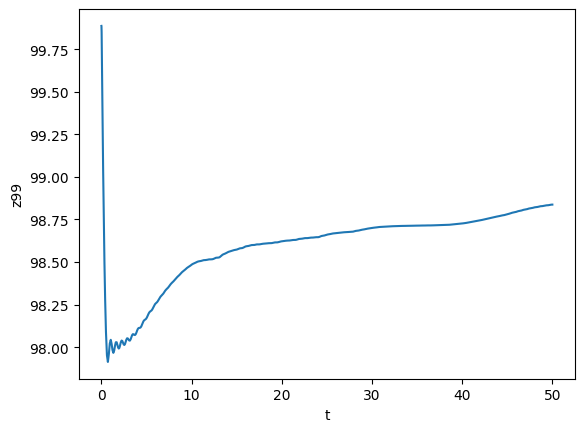

In [131]:
plt.plot(t,us.T[:,4*N + (N-1)] ,'-')
plt.xlabel('t')
plt.ylabel('z{}'.format(N-1))
plt.show()

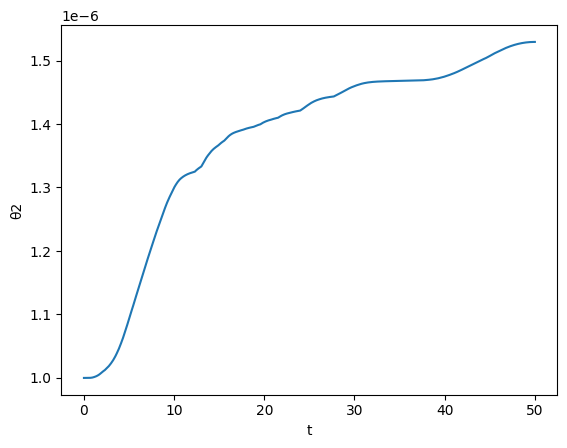

In [132]:
plt.plot(t,us.T[:,8*N+2],'-')
plt.xlabel('t')
plt.ylabel('θ2')
plt.show()

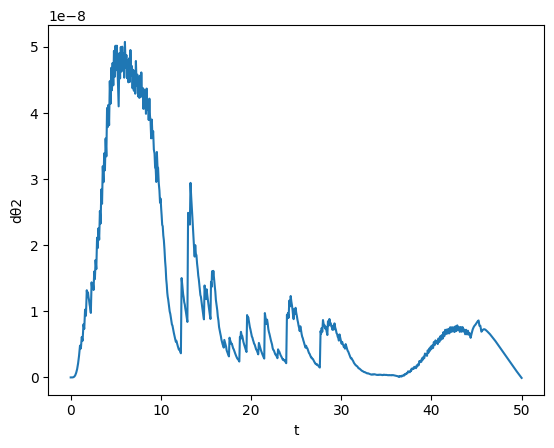

In [133]:
plt.plot(t,us.T[:,9*N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dθ2')
plt.show()

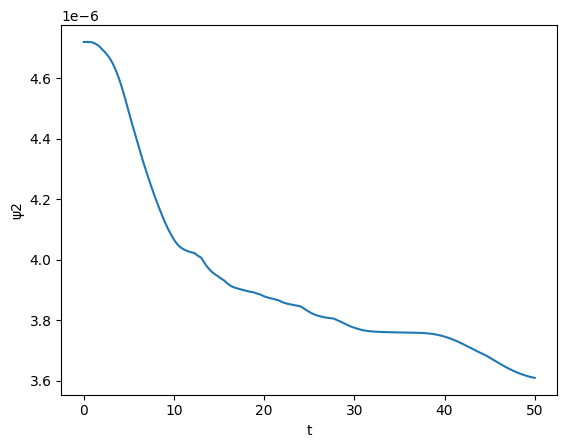

In [134]:
plt.plot(t,us.T[:,10*N+2],'-')
plt.xlabel('t')
plt.ylabel('ψ2')
plt.show()

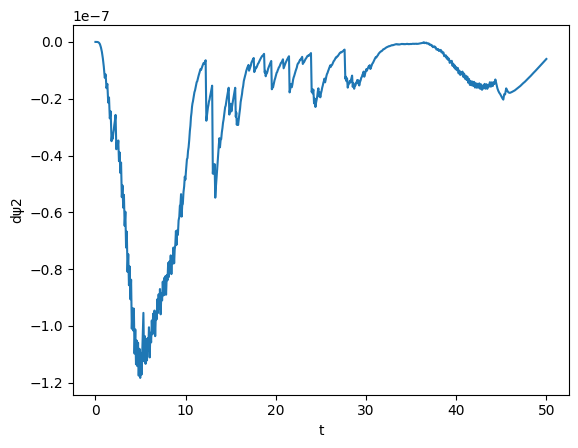

In [135]:
plt.plot(t,us.T[:,11*N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dψ2')
plt.show()

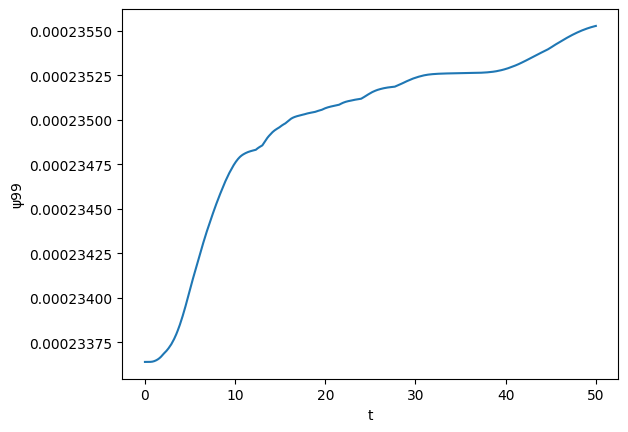

In [136]:
plt.plot(t,us.T[:,10*N + (N-1)] ,'-')
plt.xlabel('t')
plt.ylabel('ψ{}'.format(N-1))
plt.show()